<a href="https://colab.research.google.com/github/SAMYSOSERIOUS/Best-Machine-Learning-Projects-for-Beginners/blob/main/13_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN - first tries

We are implementing a simple feed-forward GAN architecture on MNIST - just to get the feeling right.

## Loading data

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np

In [2]:
(train_data,_),(test_data,_) = mnist.load_data()

In [3]:
# The more the merrier :-)
# Remember, this is unsupervised learning, so "holdout" and such makes less sense
data = np.concatenate((train_data,test_data),axis=0)

In [4]:
data.shape

(70000, 28, 28)

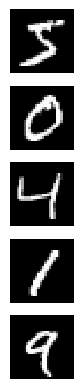

In [5]:
import matplotlib.pyplot as plt

example_count = 5

for ex in range(example_count):
    plt.subplot(5, example_count//5, ex+1)
    plt.imshow(data[ex], interpolation="nearest", cmap="gray")
    plt.axis("off")

plt.show()

In [6]:
# Normalization betwenn -1 and 1 !!!!
quasi_mean = data.max()/2 # Max is always 255, so this works ok.
data = (data.astype(np.float32)-quasi_mean)/quasi_mean

In [7]:
# Flattening of the image vectors
data = data.reshape(data.shape[0],-1)
data.shape

(70000, 784)

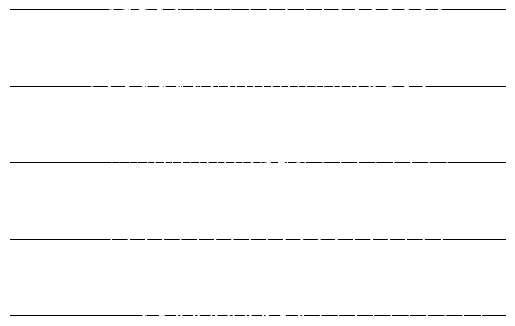

In [8]:
# Just to get the feeling, how bad this representation is...

example_count = 5

for ex in range(example_count):
    plt.subplot(5, example_count//5, ex+1)
    plt.imshow(data[ex].reshape(1,-1), interpolation="nearest", cmap="gray")
    plt.axis("off")

plt.show()

## Parameters

### Training parameters

We will be forced to do manual batching here, so we have to calcculate the number of batches manually, and iterate on a per batch basis.

In [9]:
EPOCHS = 5
BATCH_SIZE = 200
HALF_BATCH = BATCH_SIZE // 2
BATCH_NUM = (data.shape[0] // BATCH_SIZE)
if data.shape[0] % BATCH_SIZE:
    BATCH_NUM+=1
Z_DIM = 100


### Model parameters

In [10]:
GENERATOR_L1_DIM = 256
GENERATOR_L2_DIM = 512
GENERATOR_L3_DIM = 1024

DISCRIMINATOR_L1_DIM = 512
DISCRIMINATOR_L2_DIM = 256

LEAKY_ALPHA = 0.2

## Model building

In [11]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

tf.config.run_functions_eagerly(True)

# Some empirically set values.
# It might well be worth experimenting with newer optimizers / settings

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)

### Generator

In [12]:
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.models import Model

In [13]:
# The generator always gets a noise vector as input
noise_input = Input(shape=(Z_DIM,))

# Define the first layer of the fully connected network, without activation!
# Use the parameters defined with capital letter constants in the cells above for node counts!
g_layer_1 =  Dense(GENERATOR_L1_DIM)(noise_input)
# Define a non-linearioty, namely leaky relu on this layer!
# We use LeakyReLU for avoiding sparsity - other options are viable also, just not normal relu
# Use the alpha value defined in constants above!
g_layer_1_nonlin = LeakyReLU(LEAKY_ALPHA)(g_layer_1)
# You can do this as one layer, but now we do it in two. Does not matter.

# Repeat the process two more times!
g_layer_2 = Dense(GENERATOR_L2_DIM)(g_layer_1_nonlin)
g_layer_2_nonlin = LeakyReLU(LEAKY_ALPHA)(g_layer_2)

g_layer_3 = Dense(GENERATOR_L3_DIM)(g_layer_2_nonlin)
g_layer_3_nonlin = LeakyReLU(LEAKY_ALPHA)(g_layer_3)

# The output of the generator is a flattened image
# Remeber, we normalized everything between -1 and +1, so what is a nice nonlinearity, bounded between
# -1 and 1?
# Use that one as an activation for the final fully connected layer!
g_output_layer = Dense(data.shape[1], activation="tanh")(g_layer_3_nonlin)

# Please instantiate the model!
generator = Model(inputs=noise_input, outputs=g_output_layer)

# Please remeber, that the loss for the discriminator will be a binary loss, so this applies here also
# Use the appropriate loss measure!
generator.compile(loss= 'binary_crossentropy', optimizer=optimizer)
# Think about this carefully, please!

### Discriminator

In [14]:
### Define the discriminator!
#############################

# We still use FUNCTIONAL API!

# The discriminator always gets (flattened) images as inputs
# Where can you find the flattened dimensions?
# Please use a variable or property, not a hand "baked in" constant.
# That will mess up your life if the data changes...
image_input = Input(shape=(data.shape[1],))

# Following the design pattern from above, please implement two layers with nonlinearities!
d_layer_1 = Dense(DISCRIMINATOR_L1_DIM)(image_input)
d_layer_1_nonlin = LeakyReLU(LEAKY_ALPHA)(d_layer_1)
# Please implement the output layer!
# The output of the discriminator is a single binary decision,
# so one use an appropriate activation and dimensionality!
d_output_layer = Dense(1, activation="sigmoid")(d_layer_1_nonlin)

# Please instantiate the model!
discriminator = Model(inputs=image_input, outputs=d_output_layer)

# Please remeber, that the loss for the discriminator will be a binary loss, so this applies here also
# Use the appropriate loss measure!
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
# Think about this carefully, please!

### Joint model

In [15]:
### Define the GAN itself!
##########################


# STOP!!!!!!
# This is a crucial line, since in the joint model, discriminator will be frozen, so no weight update!
discriminator.trainable = True

# Remove this .... if you understand, why the above line is here!

# What is the input for the whole GAN?
# Think about the case, when the generator generates, the discriminator only discriminates it's output!
gan_input = Input(shape=(Z_DIM,))

# Use the generator as a function on the input!
generated_image = generator(gan_input)
# Use the discriminator as a function on the fake images!
gan_output = discriminator(generated_image)

# Please instantiate the model!

# Instantiate the joint model, appropriate input and output!
joint_model = Model(inputs=gan_input, outputs=gan_output)

# Create a new optimizer instance for the joint model
joint_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)

# Please think about, why it can be true, that for the joint model a binary decision is still adequate!
joint_model.compile(loss='binary_crossentropy', optimizer=joint_optimizer)
# Think about this carefully, please!
# Maybe it will get clear below in the training loop...

## Helper functions for visualization

In [16]:
# Nothing to see here! :-P

from matplotlib import pyplot as plt
import matplotlib.image as mpimg


def get_example_images(epoch, example_count=25):
    input_noise = np.random.normal(0,1, size=(example_count,Z_DIM))
    generated_images = generator.predict(input_noise)
    generated_images = generated_images.reshape(example_count, 28, 28)

    plt.figure(figsize = (5, example_count // 5))
    for ex in range(example_count):
        plt.subplot(5, example_count//5, ex+1)
        plt.imshow(generated_images[ex], interpolation="nearest", cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.savefig("example_images_epoch_num_{0}.png".format(epoch))

def show_image_for_epoch(epoch):
    imgname = "example_images_epoch_num_"+str(epoch)+".png"
    img = mpimg.imread(imgname)
    imgplot = plt.imshow(img)
    plt.show()


## Training

Sadly, we can not use simple `fit()`, but have to construct the main training loop ourselves.

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
  0%|          | 1/350 [00:00<04:14,  1.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|          | 2/350 [00:01<03:24,  1.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|          | 3/350 [00:01<03:07,  1.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|          | 4/350 [00:02<03:07,  1.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  1%|▏         | 5/350 [00:02<02:55,  1.96it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  2%|▏         | 6/350 [00:03<02:35,  2.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  2%|▏         | 7/350 [00:03<02:22,  2.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|▏         | 8/350 [00:03<02:14,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  3%|▎         | 9/350 [00:04<02:08,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  3%|▎         | 10/350 [00:04<02:05,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|▎         | 11/350 [00:04<02:02,  2.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  3%|▎         | 12/350 [00:05<02:02,  2.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  4%|▎         | 13/350 [00:05<02:01,  2.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  4%|▍         | 14/350 [00:05<01:59,  2.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|▍         | 15/350 [00:06<02:00,  2.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  5%|▍         | 16/350 [00:06<01:57,  2.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  5%|▍         | 17/350 [00:06<01:57,  2.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  5%|▌         | 18/350 [00:07<01:56,  2.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  5%|▌         | 19/350 [00:07<01:54,  2.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  6%|▌         | 20/350 [00:07<01:54,  2.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  6%|▌         | 21/350 [00:08<01:54,  2.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  6%|▋         | 22/350 [00:08<01:53,  2.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  7%|▋         | 23/350 [00:08<01:55,  2.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  7%|▋         | 24/350 [00:09<02:01,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  7%|▋         | 25/350 [00:09<02:01,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  7%|▋         | 26/350 [00:10<01:57,  2.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  8%|▊         | 27/350 [00:10<01:56,  2.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  8%|▊         | 28/350 [00:10<01:57,  2.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  8%|▊         | 29/350 [00:11<01:55,  2.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  9%|▊         | 30/350 [00:11<01:53,  2.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  9%|▉         | 31/350 [00:11<01:53,  2.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  9%|▉         | 32/350 [00:12<01:52,  2.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  9%|▉         | 33/350 [00:12<01:56,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|▉         | 34/350 [00:13<02:13,  2.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|█         | 35/350 [00:13<02:26,  2.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|█         | 36/350 [00:14<02:29,  2.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 11%|█         | 37/350 [00:14<02:31,  2.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 11%|█         | 38/350 [00:15<02:25,  2.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 11%|█         | 39/350 [00:15<02:13,  2.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 11%|█▏        | 40/350 [00:15<02:12,  2.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 12%|█▏        | 41/350 [00:16<02:04,  2.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 12%|█▏        | 42/350 [00:16<02:05,  2.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 12%|█▏        | 43/350 [00:17<01:59,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 13%|█▎        | 44/350 [00:17<01:55,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 13%|█▎        | 45/350 [00:17<01:51,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 13%|█▎        | 46/350 [00:18<01:50,  2.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 13%|█▎        | 47/350 [00:18<01:48,  2.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 14%|█▎        | 48/350 [00:18<01:46,  2.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 14%|█▍        | 49/350 [00:19<01:46,  2.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 14%|█▍        | 50/350 [00:19<01:44,  2.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 15%|█▍        | 51/350 [00:19<01:43,  2.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 15%|█▍        | 52/350 [00:20<01:44,  2.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 15%|█▌        | 53/350 [00:20<01:43,  2.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 15%|█▌        | 54/350 [00:20<01:43,  2.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 16%|█▌        | 55/350 [00:21<01:50,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 16%|█▌        | 56/350 [00:21<01:47,  2.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 16%|█▋        | 57/350 [00:21<01:44,  2.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 17%|█▋        | 58/350 [00:22<01:44,  2.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 17%|█▋        | 59/350 [00:22<01:43,  2.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 17%|█▋        | 60/350 [00:23<01:43,  2.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 17%|█▋        | 61/350 [00:23<01:43,  2.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 18%|█▊        | 62/350 [00:23<01:41,  2.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 18%|█▊        | 63/350 [00:24<01:41,  2.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 18%|█▊        | 64/350 [00:24<01:42,  2.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 19%|█▊        | 65/350 [00:24<01:41,  2.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 19%|█▉        | 66/350 [00:25<01:49,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▉        | 67/350 [00:25<02:02,  2.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▉        | 68/350 [00:26<02:09,  2.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 20%|█▉        | 69/350 [00:26<02:17,  2.04it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 20%|██        | 70/350 [00:27<02:21,  1.97it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|██        | 71/350 [00:27<02:07,  2.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 21%|██        | 72/350 [00:28<02:13,  2.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 21%|██        | 73/350 [00:28<02:02,  2.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 21%|██        | 74/350 [00:29<02:06,  2.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 21%|██▏       | 75/350 [00:29<01:56,  2.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|██▏       | 76/350 [00:29<01:50,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 22%|██▏       | 77/350 [00:30<01:45,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 22%|██▏       | 78/350 [00:30<01:41,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██▎       | 79/350 [00:30<01:40,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 23%|██▎       | 80/350 [00:31<01:37,  2.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 23%|██▎       | 81/350 [00:31<01:42,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 23%|██▎       | 82/350 [00:32<01:40,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 24%|██▎       | 83/350 [00:32<01:36,  2.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 24%|██▍       | 84/350 [00:32<01:35,  2.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 24%|██▍       | 85/350 [00:33<01:40,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 25%|██▍       | 86/350 [00:33<01:43,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 25%|██▍       | 87/350 [00:33<01:39,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 25%|██▌       | 88/350 [00:34<01:37,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 25%|██▌       | 89/350 [00:34<01:34,  2.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 26%|██▌       | 90/350 [00:35<01:34,  2.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 26%|██▌       | 91/350 [00:35<01:34,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 26%|██▋       | 92/350 [00:35<01:32,  2.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|██▋       | 93/350 [00:36<01:37,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 27%|██▋       | 94/350 [00:36<01:34,  2.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 27%|██▋       | 95/350 [00:36<01:31,  2.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 27%|██▋       | 96/350 [00:37<01:30,  2.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 28%|██▊       | 97/350 [00:37<01:31,  2.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|██▊       | 98/350 [00:38<01:41,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|██▊       | 99/350 [00:38<01:47,  2.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 29%|██▊       | 100/350 [00:39<01:50,  2.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 29%|██▉       | 101/350 [00:39<01:57,  2.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 29%|██▉       | 102/350 [00:40<01:59,  2.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 29%|██▉       | 103/350 [00:40<01:49,  2.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 30%|██▉       | 104/350 [00:40<01:41,  2.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 30%|███       | 105/350 [00:41<01:35,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 30%|███       | 106/350 [00:41<01:32,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 31%|███       | 107/350 [00:41<01:30,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███       | 108/350 [00:42<01:29,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 31%|███       | 109/350 [00:42<01:27,  2.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 31%|███▏      | 110/350 [00:42<01:31,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 32%|███▏      | 111/350 [00:43<01:29,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 32%|███▏      | 112/350 [00:43<01:27,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 32%|███▏      | 113/350 [00:43<01:24,  2.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 33%|███▎      | 114/350 [00:44<01:24,  2.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 33%|███▎      | 115/350 [00:44<01:23,  2.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|███▎      | 116/350 [00:45<01:24,  2.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 33%|███▎      | 117/350 [00:45<01:23,  2.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 34%|███▎      | 118/350 [00:45<01:21,  2.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 34%|███▍      | 119/350 [00:46<01:20,  2.86it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|███▍      | 120/350 [00:46<01:20,  2.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 35%|███▍      | 121/350 [00:46<01:19,  2.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 35%|███▍      | 122/350 [00:47<01:18,  2.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 35%|███▌      | 123/350 [00:47<01:19,  2.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 35%|███▌      | 124/350 [00:47<01:23,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 


 36%|███▌      | 125/350 [00:48<01:29,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 36%|███▌      | 126/350 [00:48<01:34,  2.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 36%|███▋      | 127/350 [00:49<01:28,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███▋      | 128/350 [00:49<01:34,  2.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 37%|███▋      | 129/350 [00:50<01:31,  2.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 37%|███▋      | 130/350 [00:50<01:37,  2.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 37%|███▋      | 131/350 [00:51<01:43,  2.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|███▊      | 132/350 [00:51<01:47,  2.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 38%|███▊      | 133/350 [00:52<01:49,  1.99it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 38%|███▊      | 134/350 [00:52<01:42,  2.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 39%|███▊      | 135/350 [00:52<01:34,  2.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 39%|███▉      | 136/350 [00:53<01:28,  2.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 39%|███▉      | 137/350 [00:53<01:23,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|███▉      | 138/350 [00:54<01:20,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 40%|███▉      | 139/350 [00:54<01:17,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 40%|████      | 140/350 [00:54<01:15,  2.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 40%|████      | 141/350 [00:55<01:15,  2.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 41%|████      | 142/350 [00:55<01:18,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 41%|████      | 143/350 [00:55<01:16,  2.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 41%|████      | 144/350 [00:56<01:15,  2.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 41%|████▏     | 145/350 [00:56<01:13,  2.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 42%|████▏     | 146/350 [00:56<01:18,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████▏     | 147/350 [00:57<01:16,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████▏     | 148/350 [00:57<01:14,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 43%|████▎     | 149/350 [00:58<01:18,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 43%|████▎     | 150/350 [00:58<01:15,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 43%|████▎     | 151/350 [00:58<01:19,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 43%|████▎     | 152/350 [00:59<01:15,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 44%|████▎     | 153/350 [00:59<01:13,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 44%|████▍     | 154/350 [00:59<01:12,  2.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 44%|████▍     | 155/350 [01:00<01:10,  2.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 45%|████▍     | 156/350 [01:00<01:09,  2.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 45%|████▍     | 157/350 [01:01<01:09,  2.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 45%|████▌     | 158/350 [01:01<01:08,  2.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 45%|████▌     | 159/350 [01:01<01:11,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 46%|████▌     | 160/350 [01:02<01:14,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 46%|████▌     | 161/350 [01:02<01:15,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 46%|████▋     | 162/350 [01:03<01:24,  2.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|████▋     | 163/350 [01:03<01:28,  2.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 47%|████▋     | 164/350 [01:04<01:33,  1.99it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 47%|████▋     | 165/350 [01:04<01:37,  1.90it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 47%|████▋     | 166/350 [01:05<01:29,  2.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████▊     | 167/350 [01:05<01:22,  2.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 48%|████▊     | 168/350 [01:06<01:17,  2.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████▊     | 169/350 [01:06<01:14,  2.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 49%|████▊     | 170/350 [01:06<01:09,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|████▉     | 171/350 [01:07<01:07,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 49%|████▉     | 172/350 [01:07<01:06,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 49%|████▉     | 173/350 [01:07<01:04,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 50%|████▉     | 174/350 [01:08<01:03,  2.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████     | 175/350 [01:08<01:03,  2.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 50%|█████     | 176/350 [01:08<01:06,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 51%|█████     | 177/350 [01:09<01:04,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 51%|█████     | 178/350 [01:09<01:02,  2.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|█████     | 179/350 [01:09<01:01,  2.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 51%|█████▏    | 180/350 [01:10<01:00,  2.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 52%|█████▏    | 181/350 [01:10<01:00,  2.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 52%|█████▏    | 182/350 [01:11<01:04,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 52%|█████▏    | 183/350 [01:11<01:02,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|█████▎    | 184/350 [01:11<01:04,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 53%|█████▎    | 185/350 [01:12<01:02,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|█████▎    | 186/350 [01:12<01:01,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████▎    | 187/350 [01:12<01:00,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|█████▎    | 188/350 [01:13<00:59,  2.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████▍    | 189/350 [01:13<01:01,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▍    | 190/350 [01:14<01:00,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 55%|█████▍    | 191/350 [01:14<00:58,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 55%|█████▍    | 192/350 [01:14<00:57,  2.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████▌    | 193/350 [01:15<01:05,  2.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████▌    | 194/350 [01:15<01:08,  2.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 56%|█████▌    | 195/350 [01:16<01:11,  2.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 56%|█████▌    | 196/350 [01:16<01:14,  2.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 56%|█████▋    | 197/350 [01:17<01:16,  2.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|█████▋    | 198/350 [01:17<01:10,  2.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|█████▋    | 199/350 [01:18<01:05,  2.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 57%|█████▋    | 200/350 [01:18<01:00,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 57%|█████▋    | 201/350 [01:18<01:01,  2.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 58%|█████▊    | 202/350 [01:19<00:58,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 58%|█████▊    | 203/350 [01:19<00:56,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|█████▊    | 204/350 [01:20<00:54,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 59%|█████▊    | 205/350 [01:20<00:53,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 59%|█████▉    | 206/350 [01:20<00:51,  2.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|█████▉    | 207/350 [01:21<00:51,  2.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|█████▉    | 208/350 [01:21<00:53,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 60%|█████▉    | 209/350 [01:21<00:56,  2.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 60%|██████    | 210/350 [01:22<00:54,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 60%|██████    | 211/350 [01:22<00:52,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 61%|██████    | 212/350 [01:23<00:51,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 61%|██████    | 213/350 [01:23<00:50,  2.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 61%|██████    | 214/350 [01:23<00:48,  2.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 61%|██████▏   | 215/350 [01:24<00:48,  2.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 62%|██████▏   | 216/350 [01:24<00:50,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 62%|██████▏   | 217/350 [01:24<00:49,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 62%|██████▏   | 218/350 [01:25<00:48,  2.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 63%|██████▎   | 219/350 [01:25<00:50,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 63%|██████▎   | 220/350 [01:26<00:52,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 63%|██████▎   | 221/350 [01:26<00:49,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 63%|██████▎   | 222/350 [01:26<00:50,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▎   | 223/350 [01:27<00:49,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 64%|██████▍   | 224/350 [01:27<00:54,  2.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 64%|██████▍   | 225/350 [01:28<00:57,  2.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|██████▍   | 226/350 [01:28<00:57,  2.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 65%|██████▍   | 227/350 [01:29<01:01,  2.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 65%|██████▌   | 228/350 [01:29<01:03,  1.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|██████▌   | 229/350 [01:30<00:57,  2.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 66%|██████▌   | 230/350 [01:30<00:52,  2.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████▌   | 231/350 [01:30<00:48,  2.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 66%|██████▋   | 232/350 [01:31<00:47,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████▋   | 233/350 [01:31<00:45,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 67%|██████▋   | 234/350 [01:32<00:47,  2.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 235/350 [01:32<00:47,  2.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 67%|██████▋   | 236/350 [01:32<00:44,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 68%|██████▊   | 237/350 [01:33<00:45,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 68%|██████▊   | 238/350 [01:33<00:43,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 68%|██████▊   | 239/350 [01:34<00:41,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 69%|██████▊   | 240/350 [01:34<00:41,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 69%|██████▉   | 241/350 [01:34<00:39,  2.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 69%|██████▉   | 242/350 [01:35<00:39,  2.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 69%|██████▉   | 243/350 [01:35<00:41,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 70%|██████▉   | 244/350 [01:35<00:40,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 70%|███████   | 245/350 [01:36<00:39,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 70%|███████   | 246/350 [01:36<00:40,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 71%|███████   | 247/350 [01:37<00:38,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 71%|███████   | 248/350 [01:37<00:40,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 71%|███████   | 249/350 [01:37<00:38,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 71%|███████▏  | 250/350 [01:38<00:37,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 72%|███████▏  | 251/350 [01:38<00:36,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 72%|███████▏  | 252/350 [01:38<00:35,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 72%|███████▏  | 253/350 [01:39<00:34,  2.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 73%|███████▎  | 254/350 [01:39<00:37,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|███████▎  | 255/350 [01:40<00:39,  2.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 73%|███████▎  | 256/350 [01:40<00:41,  2.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 73%|███████▎  | 257/350 [01:41<00:42,  2.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 74%|███████▎  | 258/350 [01:41<00:43,  2.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 74%|███████▍  | 259/350 [01:42<00:46,  1.97it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▍  | 260/350 [01:42<00:42,  2.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 75%|███████▍  | 261/350 [01:43<00:38,  2.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|███████▍  | 262/350 [01:43<00:36,  2.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 75%|███████▌  | 263/350 [01:43<00:34,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 75%|███████▌  | 264/350 [01:44<00:33,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 76%|███████▌  | 265/350 [01:44<00:31,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 76%|███████▌  | 266/350 [01:44<00:30,  2.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 76%|███████▋  | 267/350 [01:45<00:30,  2.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 77%|███████▋  | 268/350 [01:45<00:29,  2.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 77%|███████▋  | 269/350 [01:45<00:29,  2.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 77%|███████▋  | 270/350 [01:46<00:30,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|███████▋  | 271/350 [01:46<00:29,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 78%|███████▊  | 272/350 [01:46<00:28,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████▊  | 273/350 [01:47<00:28,  2.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 78%|███████▊  | 274/350 [01:47<00:28,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 79%|███████▊  | 275/350 [01:48<00:28,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 79%|███████▉  | 276/350 [01:48<00:26,  2.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 79%|███████▉  | 277/350 [01:48<00:25,  2.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 79%|███████▉  | 278/350 [01:49<00:25,  2.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 80%|███████▉  | 279/350 [01:49<00:25,  2.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 80%|████████  | 280/350 [01:49<00:26,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 80%|████████  | 281/350 [01:50<00:25,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 81%|████████  | 282/350 [01:50<00:24,  2.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|████████  | 283/350 [01:51<00:24,  2.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 284/350 [01:51<00:24,  2.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|████████▏ | 285/350 [01:51<00:23,  2.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 82%|████████▏ | 286/350 [01:52<00:23,  2.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 82%|████████▏ | 287/350 [01:52<00:25,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 82%|████████▏ | 288/350 [01:53<00:26,  2.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 83%|████████▎ | 289/350 [01:53<00:28,  2.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████▎ | 290/350 [01:54<00:29,  2.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████▎ | 291/350 [01:54<00:29,  1.98it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 83%|████████▎ | 292/350 [01:55<00:28,  2.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|████████▎ | 293/350 [01:55<00:25,  2.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 84%|████████▍ | 294/350 [01:55<00:24,  2.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 84%|████████▍ | 295/350 [01:56<00:22,  2.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 85%|████████▍ | 296/350 [01:56<00:21,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 85%|████████▍ | 297/350 [01:57<00:20,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 85%|████████▌ | 298/350 [01:57<00:20,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 85%|████████▌ | 299/350 [01:57<00:19,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▌ | 300/350 [01:58<00:18,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 86%|████████▌ | 301/350 [01:58<00:18,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 86%|████████▋ | 302/350 [01:58<00:17,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|████████▋ | 303/350 [01:59<00:17,  2.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|████████▋ | 304/350 [01:59<00:16,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|████████▋ | 305/350 [01:59<00:16,  2.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 306/350 [02:00<00:16,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 88%|████████▊ | 307/350 [02:00<00:15,  2.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 88%|████████▊ | 308/350 [02:01<00:15,  2.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 88%|████████▊ | 309/350 [02:01<00:15,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▊ | 310/350 [02:01<00:14,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 89%|████████▉ | 311/350 [02:02<00:14,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 89%|████████▉ | 312/350 [02:02<00:13,  2.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 89%|████████▉ | 313/350 [02:02<00:13,  2.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|████████▉ | 314/350 [02:03<00:13,  2.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|█████████ | 315/350 [02:03<00:12,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|█████████ | 316/350 [02:04<00:12,  2.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████ | 317/350 [02:04<00:11,  2.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████ | 318/350 [02:04<00:11,  2.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 91%|█████████ | 319/350 [02:05<00:12,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 91%|█████████▏| 320/350 [02:05<00:12,  2.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 92%|█████████▏| 321/350 [02:06<00:13,  2.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 92%|█████████▏| 322/350 [02:06<00:13,  2.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 92%|█████████▏| 323/350 [02:07<00:13,  1.99it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 93%|█████████▎| 324/350 [02:07<00:12,  2.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 325/350 [02:08<00:11,  2.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 93%|█████████▎| 326/350 [02:08<00:10,  2.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 93%|█████████▎| 327/350 [02:08<00:09,  2.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|█████████▎| 328/350 [02:09<00:10,  2.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|█████████▍| 329/350 [02:09<00:09,  2.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 94%|█████████▍| 330/350 [02:10<00:08,  2.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 95%|█████████▍| 331/350 [02:10<00:07,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▍| 332/350 [02:10<00:06,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 95%|█████████▌| 333/350 [02:11<00:06,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 95%|█████████▌| 334/350 [02:11<00:05,  2.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 96%|█████████▌| 335/350 [02:11<00:05,  2.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 96%|█████████▌| 336/350 [02:12<00:05,  2.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 96%|█████████▋| 337/350 [02:12<00:04,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 97%|█████████▋| 338/350 [02:13<00:04,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 97%|█████████▋| 339/350 [02:13<00:04,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 97%|█████████▋| 340/350 [02:13<00:03,  2.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 97%|█████████▋| 341/350 [02:14<00:03,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 98%|█████████▊| 342/350 [02:14<00:03,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|█████████▊| 343/350 [02:14<00:02,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|█████████▊| 344/350 [02:15<00:02,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 99%|█████████▊| 345/350 [02:15<00:01,  2.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 99%|█████████▉| 346/350 [02:16<00:01,  2.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 347/350 [02:16<00:01,  2.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 99%|█████████▉| 348/350 [02:16<00:00,  2.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


100%|█████████▉| 349/350 [02:17<00:00,  2.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|██████████| 350/350 [02:17<00:00,  2.55it/s]

Epoch number: 0 discriminator_loss: 1.3711066148962294 generator_loss: 0.22528704370771135
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


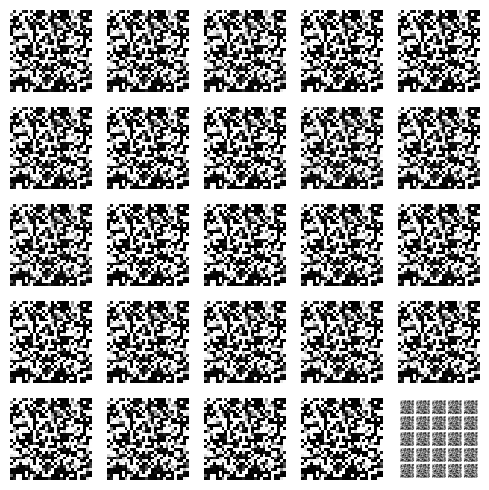

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  0%|          | 1/350 [00:00<03:11,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  1%|          | 2/350 [00:01<03:06,  1.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  1%|          | 3/350 [00:01<03:12,  1.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  1%|          | 4/350 [00:02<02:47,  2.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  1%|▏         | 5/350 [00:02<02:30,  2.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|▏         | 6/350 [00:02<02:21,  2.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|▏         | 7/350 [00:03<02:16,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  2%|▏         | 8/350 [00:03<02:11,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  3%|▎         | 9/350 [00:03<02:08,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|▎         | 10/350 [00:04<02:10,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|▎         | 11/350 [00:04<02:13,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|▎         | 12/350 [00:05<02:15,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  4%|▎         | 13/350 [00:05<02:18,  2.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|▍         | 14/350 [00:05<02:12,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  4%|▍         | 15/350 [00:06<02:07,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|▍         | 16/350 [00:06<02:07,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|▍         | 17/350 [00:06<02:04,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  5%|▌         | 18/350 [00:07<02:02,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|▌         | 19/350 [00:07<02:01,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|▌         | 20/350 [00:08<02:01,  2.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|▌         | 21/350 [00:08<02:07,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|▋         | 22/350 [00:08<02:06,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|▋         | 23/350 [00:09<02:03,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  7%|▋         | 24/350 [00:09<02:01,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|▋         | 25/350 [00:09<02:06,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|▋         | 26/350 [00:10<02:02,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  8%|▊         | 27/350 [00:10<02:00,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  8%|▊         | 28/350 [00:11<01:57,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  8%|▊         | 29/350 [00:11<01:58,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  9%|▊         | 30/350 [00:11<02:01,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  9%|▉         | 31/350 [00:12<02:13,  2.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  9%|▉         | 32/350 [00:12<02:24,  2.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|▉         | 33/350 [00:13<02:26,  2.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 10%|▉         | 34/350 [00:13<02:33,  2.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 10%|█         | 35/350 [00:14<02:35,  2.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 10%|█         | 36/350 [00:14<02:23,  2.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 11%|█         | 37/350 [00:15<02:12,  2.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 11%|█         | 38/350 [00:15<02:05,  2.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 11%|█         | 39/350 [00:15<02:01,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 11%|█▏        | 40/350 [00:16<01:56,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 12%|█▏        | 41/350 [00:16<01:53,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 12%|█▏        | 42/350 [00:16<01:53,  2.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█▏        | 43/350 [00:17<01:51,  2.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 13%|█▎        | 44/350 [00:17<01:50,  2.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|█▎        | 45/350 [00:18<01:52,  2.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|█▎        | 46/350 [00:18<01:50,  2.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█▎        | 47/350 [00:18<01:48,  2.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|█▎        | 48/350 [00:19<01:49,  2.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 14%|█▍        | 49/350 [00:19<01:48,  2.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|█▍        | 50/350 [00:19<01:47,  2.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▍        | 51/350 [00:20<01:48,  2.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|█▍        | 52/350 [00:20<01:48,  2.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|█▌        | 53/350 [00:20<01:48,  2.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 15%|█▌        | 54/350 [00:21<01:46,  2.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 16%|█▌        | 55/350 [00:21<01:51,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 16%|█▌        | 56/350 [00:22<01:50,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 16%|█▋        | 57/350 [00:22<01:48,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█▋        | 58/350 [00:22<01:46,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█▋        | 59/350 [00:23<01:49,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█▋        | 60/350 [00:23<01:47,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 17%|█▋        | 61/350 [00:23<01:46,  2.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█▊        | 62/350 [00:24<01:44,  2.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 18%|█▊        | 63/350 [00:24<01:53,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 18%|█▊        | 64/350 [00:25<02:05,  2.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▊        | 65/350 [00:25<02:13,  2.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|█▉        | 66/350 [00:26<02:21,  2.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|█▉        | 67/350 [00:26<02:22,  1.98it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|█▉        | 68/350 [00:27<02:09,  2.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 20%|█▉        | 69/350 [00:27<02:00,  2.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 20%|██        | 70/350 [00:27<01:53,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 20%|██        | 71/350 [00:28<01:49,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 72/350 [00:28<01:45,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 21%|██        | 73/350 [00:28<01:44,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 74/350 [00:29<01:48,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 21%|██▏       | 75/350 [00:29<01:45,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|██▏       | 76/350 [00:30<01:41,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 22%|██▏       | 77/350 [00:30<01:39,  2.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 78/350 [00:30<01:38,  2.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 23%|██▎       | 79/350 [00:31<01:43,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 23%|██▎       | 80/350 [00:31<01:42,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 23%|██▎       | 81/350 [00:31<01:39,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|██▎       | 82/350 [00:32<01:37,  2.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 24%|██▎       | 83/350 [00:32<01:37,  2.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██▍       | 84/350 [00:33<01:35,  2.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 24%|██▍       | 85/350 [00:33<01:35,  2.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|██▍       | 86/350 [00:33<01:34,  2.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|██▍       | 87/350 [00:34<01:32,  2.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 25%|██▌       | 88/350 [00:34<01:33,  2.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██▌       | 89/350 [00:34<01:33,  2.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|██▌       | 90/350 [00:35<01:33,  2.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 26%|██▌       | 91/350 [00:35<01:34,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 26%|██▋       | 92/350 [00:35<01:38,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|██▋       | 93/350 [00:36<01:35,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 27%|██▋       | 94/350 [00:36<01:34,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██▋       | 95/350 [00:37<01:43,  2.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|██▋       | 96/350 [00:37<01:50,  2.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 28%|██▊       | 97/350 [00:38<01:56,  2.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|██▊       | 98/350 [00:38<02:04,  2.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 28%|██▊       | 99/350 [00:39<02:10,  1.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▊       | 100/350 [00:39<01:59,  2.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▉       | 101/350 [00:40<01:50,  2.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▉       | 102/350 [00:40<01:42,  2.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 29%|██▉       | 103/350 [00:40<01:39,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 30%|██▉       | 104/350 [00:41<01:35,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 30%|███       | 105/350 [00:41<01:32,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 30%|███       | 106/350 [00:41<01:31,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 31%|███       | 107/350 [00:42<01:34,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███       | 108/350 [00:42<01:31,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███       | 109/350 [00:43<01:30,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███▏      | 110/350 [00:43<01:28,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|███▏      | 111/350 [00:43<01:27,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 32%|███▏      | 112/350 [00:44<01:27,  2.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 32%|███▏      | 113/350 [00:44<01:25,  2.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███▎      | 114/350 [00:44<01:24,  2.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|███▎      | 115/350 [00:45<01:27,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|███▎      | 116/350 [00:45<01:29,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███▎      | 117/350 [00:46<01:34,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|███▎      | 118/350 [00:46<01:32,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|███▍      | 119/350 [00:46<01:30,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|███▍      | 120/350 [00:47<01:28,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███▍      | 121/350 [00:47<01:25,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███▍      | 122/350 [00:47<01:23,  2.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|███▌      | 123/350 [00:48<01:24,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 35%|███▌      | 124/350 [00:48<01:21,  2.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███▌      | 125/350 [00:49<01:21,  2.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 36%|███▌      | 126/350 [00:49<01:20,  2.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 36%|███▋      | 127/350 [00:49<01:32,  2.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 37%|███▋      | 128/350 [00:50<01:40,  2.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 37%|███▋      | 129/350 [00:50<01:41,  2.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 37%|███▋      | 130/350 [00:51<01:47,  2.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 37%|███▋      | 131/350 [00:51<01:48,  2.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|███▊      | 132/350 [00:52<01:44,  2.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|███▊      | 133/350 [00:52<01:36,  2.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|███▊      | 134/350 [00:53<01:34,  2.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|███▊      | 135/350 [00:53<01:29,  2.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 39%|███▉      | 136/350 [00:53<01:24,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|███▉      | 137/350 [00:54<01:23,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|███▉      | 138/350 [00:54<01:24,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|███▉      | 139/350 [00:55<01:21,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 40%|████      | 140/350 [00:55<01:19,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|████      | 141/350 [00:55<01:22,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|████      | 142/350 [00:56<01:19,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 41%|████      | 143/350 [00:56<01:19,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 41%|████      | 144/350 [00:56<01:17,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|████▏     | 145/350 [00:57<01:14,  2.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 42%|████▏     | 146/350 [00:57<01:19,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 42%|████▏     | 147/350 [00:58<01:16,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████▏     | 148/350 [00:58<01:16,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 43%|████▎     | 149/350 [00:58<01:15,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 43%|████▎     | 150/350 [00:59<01:17,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 43%|████▎     | 151/350 [00:59<01:15,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 43%|████▎     | 152/350 [01:00<01:17,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|████▎     | 153/350 [01:00<01:14,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|████▍     | 154/350 [01:00<01:13,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|████▍     | 155/350 [01:01<01:11,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 45%|████▍     | 156/350 [01:01<01:11,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|████▍     | 157/350 [01:01<01:11,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 45%|████▌     | 158/350 [01:02<01:19,  2.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|████▌     | 159/350 [01:02<01:25,  2.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 46%|████▌     | 160/350 [01:03<01:29,  2.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 46%|████▌     | 161/350 [01:03<01:34,  2.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 46%|████▋     | 162/350 [01:04<01:33,  2.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 47%|████▋     | 163/350 [01:04<01:26,  2.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 47%|████▋     | 164/350 [01:05<01:19,  2.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 47%|████▋     | 165/350 [01:05<01:20,  2.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 47%|████▋     | 166/350 [01:06<01:17,  2.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████▊     | 167/350 [01:06<01:13,  2.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████▊     | 168/350 [01:06<01:11,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 48%|████▊     | 169/350 [01:07<01:09,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|████▊     | 170/350 [01:07<01:07,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 49%|████▉     | 171/350 [01:07<01:06,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 49%|████▉     | 172/350 [01:08<01:04,  2.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 49%|████▉     | 173/350 [01:08<01:03,  2.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|████▉     | 174/350 [01:08<01:03,  2.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 50%|█████     | 175/350 [01:09<01:02,  2.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 50%|█████     | 176/350 [01:09<01:05,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|█████     | 177/350 [01:10<01:04,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|█████     | 178/350 [01:10<01:03,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|█████     | 179/350 [01:10<01:02,  2.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 51%|█████▏    | 180/350 [01:11<01:01,  2.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 52%|█████▏    | 181/350 [01:11<01:00,  2.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 52%|█████▏    | 182/350 [01:11<00:59,  2.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 52%|█████▏    | 183/350 [01:12<00:59,  2.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|█████▎    | 184/350 [01:12<00:59,  2.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████▎    | 185/350 [01:12<00:58,  2.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|█████▎    | 186/350 [01:13<00:58,  2.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|█████▎    | 187/350 [01:13<00:57,  2.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████▎    | 188/350 [01:13<00:57,  2.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████▍    | 189/350 [01:14<00:58,  2.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 54%|█████▍    | 190/350 [01:14<01:05,  2.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▍    | 191/350 [01:15<01:12,  2.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 55%|█████▍    | 192/350 [01:15<01:14,  2.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 55%|█████▌    | 193/350 [01:16<01:18,  2.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 55%|█████▌    | 194/350 [01:17<01:20,  1.94it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 56%|█████▌    | 195/350 [01:17<01:12,  2.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▌    | 196/350 [01:17<01:07,  2.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|█████▋    | 197/350 [01:18<01:02,  2.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|█████▋    | 198/350 [01:18<01:01,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|█████▋    | 199/350 [01:18<00:58,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|█████▋    | 200/350 [01:19<00:56,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 57%|█████▋    | 201/350 [01:19<00:59,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|█████▊    | 202/350 [01:20<00:56,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 58%|█████▊    | 203/350 [01:20<00:55,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|█████▊    | 204/350 [01:20<00:54,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|█████▊    | 205/350 [01:21<00:53,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████▉    | 206/350 [01:21<00:52,  2.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████▉    | 207/350 [01:21<00:52,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████▉    | 208/350 [01:22<00:51,  2.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 60%|█████▉    | 209/350 [01:22<00:53,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|██████    | 210/350 [01:22<00:52,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|██████    | 211/350 [01:23<00:50,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 61%|██████    | 212/350 [01:23<00:51,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 61%|██████    | 213/350 [01:24<00:50,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 61%|██████    | 214/350 [01:24<00:48,  2.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 61%|██████▏   | 215/350 [01:24<00:49,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 62%|██████▏   | 216/350 [01:25<00:51,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 62%|██████▏   | 217/350 [01:25<00:50,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 218/350 [01:25<00:49,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 63%|██████▎   | 219/350 [01:26<00:48,  2.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 63%|██████▎   | 220/350 [01:26<00:48,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 221/350 [01:27<00:48,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 63%|██████▎   | 222/350 [01:27<00:55,  2.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████▎   | 223/350 [01:28<00:57,  2.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|██████▍   | 224/350 [01:28<01:00,  2.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 64%|██████▍   | 225/350 [01:29<01:04,  1.94it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 65%|██████▍   | 226/350 [01:29<01:03,  1.95it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|██████▍   | 227/350 [01:30<00:57,  2.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|██████▌   | 228/350 [01:30<01:02,  1.95it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|██████▌   | 229/350 [01:31<01:06,  1.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 66%|██████▌   | 230/350 [01:31<01:05,  1.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|██████▌   | 231/350 [01:32<01:00,  1.97it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|██████▋   | 232/350 [01:32<00:56,  2.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|██████▋   | 233/350 [01:33<00:54,  2.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|██████▋   | 234/350 [01:33<00:52,  2.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 235/350 [01:34<00:50,  2.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 67%|██████▋   | 236/350 [01:34<00:49,  2.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 68%|██████▊   | 237/350 [01:34<00:52,  2.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████▊   | 238/350 [01:35<00:51,  2.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|██████▊   | 239/350 [01:35<00:50,  2.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 69%|██████▊   | 240/350 [01:36<00:49,  2.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|██████▉   | 241/350 [01:36<00:48,  2.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████▉   | 242/350 [01:37<00:49,  2.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 69%|██████▉   | 243/350 [01:37<00:52,  2.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 70%|██████▉   | 244/350 [01:38<00:54,  1.95it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 70%|███████   | 245/350 [01:38<00:54,  1.94it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 70%|███████   | 246/350 [01:39<00:48,  2.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 71%|███████   | 247/350 [01:39<00:47,  2.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 71%|███████   | 248/350 [01:40<00:50,  2.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 71%|███████   | 249/350 [01:40<00:51,  1.95it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|███████▏  | 250/350 [01:41<00:50,  1.98it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 72%|███████▏  | 251/350 [01:41<00:52,  1.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 72%|███████▏  | 252/350 [01:42<00:52,  1.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 72%|███████▏  | 253/350 [01:42<00:47,  2.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 73%|███████▎  | 254/350 [01:43<00:42,  2.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 73%|███████▎  | 255/350 [01:43<00:39,  2.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|███████▎  | 256/350 [01:43<00:38,  2.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|███████▎  | 257/350 [01:44<00:36,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▎  | 258/350 [01:44<00:35,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▍  | 259/350 [01:45<00:34,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|███████▍  | 260/350 [01:45<00:33,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 75%|███████▍  | 261/350 [01:45<00:32,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|███████▍  | 262/350 [01:46<00:32,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|███████▌  | 263/350 [01:46<00:32,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|███████▌  | 264/350 [01:46<00:31,  2.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 76%|███████▌  | 265/350 [01:47<00:31,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 76%|███████▌  | 266/350 [01:47<00:30,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████▋  | 267/350 [01:47<00:31,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████▋  | 268/350 [01:48<00:30,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|███████▋  | 269/350 [01:48<00:31,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|███████▋  | 270/350 [01:49<00:30,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|███████▋  | 271/350 [01:49<00:29,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████▊  | 272/350 [01:49<00:28,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████▊  | 273/350 [01:50<00:28,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 78%|███████▊  | 274/350 [01:50<00:29,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|███████▊  | 275/350 [01:50<00:28,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|███████▉  | 276/350 [01:51<00:27,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 79%|███████▉  | 277/350 [01:51<00:26,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████▉  | 278/350 [01:52<00:26,  2.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 80%|███████▉  | 279/350 [01:52<00:26,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 80%|████████  | 280/350 [01:53<00:29,  2.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 80%|████████  | 281/350 [01:53<00:30,  2.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 81%|████████  | 282/350 [01:54<00:32,  2.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 81%|████████  | 283/350 [01:54<00:33,  2.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 81%|████████  | 284/350 [01:55<00:32,  2.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|████████▏ | 285/350 [01:55<00:30,  2.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 286/350 [01:55<00:27,  2.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 82%|████████▏ | 287/350 [01:56<00:26,  2.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 82%|████████▏ | 288/350 [01:56<00:25,  2.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 83%|████████▎ | 289/350 [01:56<00:23,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 290/350 [01:57<00:22,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████▎ | 291/350 [01:57<00:22,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 292/350 [01:58<00:21,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 84%|████████▎ | 293/350 [01:58<00:20,  2.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 84%|████████▍ | 294/350 [01:58<00:20,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 84%|████████▍ | 295/350 [01:59<00:20,  2.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████▍ | 296/350 [01:59<00:19,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████▍ | 297/350 [01:59<00:19,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 85%|████████▌ | 298/350 [02:00<00:18,  2.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████▌ | 299/350 [02:00<00:18,  2.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|████████▌ | 300/350 [02:00<00:18,  2.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|████████▌ | 301/350 [02:01<00:17,  2.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|████████▋ | 302/350 [02:01<00:17,  2.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 303/350 [02:02<00:17,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|████████▋ | 304/350 [02:02<00:16,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|████████▋ | 305/350 [02:02<00:16,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|████████▋ | 306/350 [02:03<00:16,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 307/350 [02:03<00:16,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 88%|████████▊ | 308/350 [02:03<00:15,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|████████▊ | 309/350 [02:04<00:15,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 89%|████████▊ | 310/350 [02:04<00:14,  2.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▉ | 311/350 [02:05<00:14,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 89%|████████▉ | 312/350 [02:05<00:15,  2.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 89%|████████▉ | 313/350 [02:06<00:16,  2.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 90%|████████▉ | 314/350 [02:06<00:16,  2.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 90%|█████████ | 315/350 [02:07<00:17,  2.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 90%|█████████ | 316/350 [02:07<00:17,  1.94it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 91%|█████████ | 317/350 [02:08<00:16,  2.04it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████ | 318/350 [02:08<00:14,  2.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████ | 319/350 [02:08<00:13,  2.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 91%|█████████▏| 320/350 [02:09<00:12,  2.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████▏| 321/350 [02:09<00:11,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 92%|█████████▏| 322/350 [02:10<00:11,  2.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 323/350 [02:10<00:10,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 93%|█████████▎| 324/350 [02:10<00:10,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 93%|█████████▎| 325/350 [02:11<00:09,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 326/350 [02:11<00:09,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 93%|█████████▎| 327/350 [02:11<00:08,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|█████████▎| 328/350 [02:12<00:08,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 94%|█████████▍| 329/350 [02:12<00:08,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▍| 330/350 [02:13<00:07,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 95%|█████████▍| 331/350 [02:13<00:07,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|█████████▍| 332/350 [02:13<00:06,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▌| 333/350 [02:14<00:06,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 95%|█████████▌| 334/350 [02:14<00:05,  2.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 96%|█████████▌| 335/350 [02:14<00:05,  2.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|█████████▌| 336/350 [02:15<00:05,  2.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|█████████▋| 337/350 [02:15<00:04,  2.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████▋| 338/350 [02:15<00:04,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 97%|█████████▋| 339/350 [02:16<00:04,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████▋| 340/350 [02:16<00:03,  2.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|█████████▋| 341/350 [02:17<00:03,  2.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 98%|█████████▊| 342/350 [02:17<00:02,  2.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|█████████▊| 343/350 [02:17<00:02,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 98%|█████████▊| 344/350 [02:18<00:02,  2.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 99%|█████████▊| 345/350 [02:19<00:02,  2.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 99%|█████████▉| 346/350 [02:19<00:01,  2.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 99%|█████████▉| 347/350 [02:20<00:01,  1.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▉| 348/350 [02:20<00:00,  2.04it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


100%|█████████▉| 349/350 [02:20<00:00,  2.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


100%|██████████| 350/350 [02:21<00:00,  2.48it/s]

Epoch number: 1 discriminator_loss: 1.3676260551384518 generator_loss: 0.28985600318227495
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


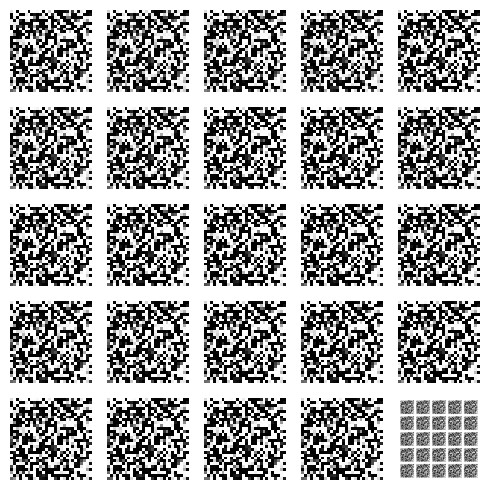

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|          | 1/350 [00:00<02:07,  2.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  1%|          | 2/350 [00:00<02:07,  2.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|          | 3/350 [00:01<02:07,  2.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|          | 4/350 [00:01<02:07,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▏         | 5/350 [00:01<02:10,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  2%|▏         | 6/350 [00:02<02:15,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|▏         | 7/350 [00:02<02:12,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|▏         | 8/350 [00:03<02:11,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|▎         | 9/350 [00:03<02:08,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 10/350 [00:03<02:06,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|▎         | 11/350 [00:04<02:06,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|▎         | 12/350 [00:04<02:05,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|▎         | 13/350 [00:04<02:06,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  4%|▍         | 14/350 [00:05<02:04,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|▍         | 15/350 [00:05<02:03,  2.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|▍         | 16/350 [00:05<02:03,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|▍         | 17/350 [00:06<02:03,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|▌         | 18/350 [00:06<02:01,  2.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  5%|▌         | 19/350 [00:07<02:07,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|▌         | 20/350 [00:07<02:04,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|▌         | 21/350 [00:07<02:03,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|▋         | 22/350 [00:08<02:03,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 23/350 [00:08<02:18,  2.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  7%|▋         | 24/350 [00:09<02:30,  2.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  7%|▋         | 25/350 [00:09<02:35,  2.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 26/350 [00:10<02:42,  2.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  8%|▊         | 27/350 [00:10<02:47,  1.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  8%|▊         | 28/350 [00:11<02:33,  2.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|▊         | 29/350 [00:11<02:21,  2.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|▊         | 30/350 [00:12<02:12,  2.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|▉         | 31/350 [00:12<02:08,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|▉         | 32/350 [00:12<02:03,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▉         | 33/350 [00:13<02:03,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|▉         | 34/350 [00:13<02:01,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 10%|█         | 35/350 [00:13<01:59,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|█         | 36/350 [00:14<01:59,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█         | 37/350 [00:14<01:57,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|█         | 38/350 [00:15<01:56,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█         | 39/350 [00:15<01:57,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|█▏        | 40/350 [00:15<01:55,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█▏        | 41/350 [00:16<01:54,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 12%|█▏        | 42/350 [00:16<01:53,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█▏        | 43/350 [00:16<01:53,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 13%|█▎        | 44/350 [00:17<01:52,  2.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|█▎        | 45/350 [00:17<01:54,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|█▎        | 46/350 [00:18<01:53,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 13%|█▎        | 47/350 [00:18<01:53,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|█▎        | 48/350 [00:18<01:52,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|█▍        | 49/350 [00:19<01:51,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|█▍        | 50/350 [00:19<01:52,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▍        | 51/350 [00:19<01:53,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▍        | 52/350 [00:20<01:51,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▌        | 53/350 [00:20<01:51,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|█▌        | 54/350 [00:21<01:54,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 16%|█▌        | 55/350 [00:21<02:08,  2.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 56/350 [00:22<02:18,  2.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▋        | 57/350 [00:22<02:27,  1.99it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 17%|█▋        | 58/350 [00:23<02:31,  1.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 17%|█▋        | 59/350 [00:23<02:24,  2.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█▋        | 60/350 [00:24<02:12,  2.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█▋        | 61/350 [00:24<02:04,  2.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█▊        | 62/350 [00:24<02:05,  2.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█▊        | 63/350 [00:25<01:59,  2.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█▊        | 64/350 [00:25<01:55,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|█▊        | 65/350 [00:26<01:54,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|█▉        | 66/350 [00:26<01:50,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|█▉        | 67/350 [00:26<01:49,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 19%|█▉        | 68/350 [00:27<01:49,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 20%|█▉        | 69/350 [00:27<01:46,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|██        | 70/350 [00:27<01:47,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|██        | 71/350 [00:28<01:45,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 72/350 [00:28<01:44,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|██        | 73/350 [00:29<01:48,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 74/350 [00:29<01:45,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|██▏       | 75/350 [00:29<01:44,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 76/350 [00:30<01:43,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|██▏       | 77/350 [00:30<01:42,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 22%|██▏       | 78/350 [00:30<01:42,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|██▎       | 79/350 [00:31<01:41,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██▎       | 80/350 [00:31<01:40,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|██▎       | 81/350 [00:32<01:40,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|██▎       | 82/350 [00:32<01:39,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 24%|██▎       | 83/350 [00:32<01:37,  2.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██▍       | 84/350 [00:33<01:38,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██▍       | 85/350 [00:33<01:38,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 25%|██▍       | 86/350 [00:34<01:54,  2.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 25%|██▍       | 87/350 [00:34<02:03,  2.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 25%|██▌       | 88/350 [00:35<02:12,  1.98it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 25%|██▌       | 89/350 [00:35<02:16,  1.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 26%|██▌       | 90/350 [00:36<02:12,  1.96it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 26%|██▌       | 91/350 [00:36<02:00,  2.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|██▋       | 92/350 [00:37<01:52,  2.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|██▋       | 93/350 [00:37<01:47,  2.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 94/350 [00:37<01:43,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|██▋       | 95/350 [00:38<01:39,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 96/350 [00:38<01:38,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 97/350 [00:38<01:36,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|██▊       | 98/350 [00:39<01:35,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 99/350 [00:39<01:35,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▊       | 100/350 [00:40<01:33,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▉       | 101/350 [00:40<01:32,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▉       | 102/350 [00:40<01:31,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██▉       | 103/350 [00:41<01:31,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 30%|██▉       | 104/350 [00:41<01:31,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███       | 105/350 [00:41<01:31,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███       | 106/350 [00:42<01:30,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███       | 107/350 [00:42<01:31,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 31%|███       | 108/350 [00:42<01:30,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███       | 109/350 [00:43<01:29,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 31%|███▏      | 110/350 [00:43<01:32,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|███▏      | 111/350 [00:44<01:31,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███▏      | 112/350 [00:44<01:31,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|███▏      | 113/350 [00:44<01:30,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███▎      | 114/350 [00:45<01:28,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|███▎      | 115/350 [00:45<01:29,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███▎      | 116/350 [00:46<01:27,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███▎      | 117/350 [00:46<01:34,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 34%|███▎      | 118/350 [00:47<01:44,  2.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 34%|███▍      | 119/350 [00:47<01:48,  2.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 34%|███▍      | 120/350 [00:48<01:55,  1.98it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 35%|███▍      | 121/350 [00:48<01:58,  1.94it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███▍      | 122/350 [00:49<01:49,  2.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███▌      | 123/350 [00:49<01:41,  2.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███▌      | 124/350 [00:49<01:37,  2.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 36%|███▌      | 125/350 [00:50<01:32,  2.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███▌      | 126/350 [00:50<01:28,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███▋      | 127/350 [00:50<01:28,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███▋      | 128/350 [00:51<01:25,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███▋      | 129/350 [00:51<01:23,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███▋      | 130/350 [00:52<01:23,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███▋      | 131/350 [00:52<01:21,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|███▊      | 132/350 [00:52<01:21,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 38%|███▊      | 133/350 [00:53<01:21,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|███▊      | 134/350 [00:53<01:20,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|███▊      | 135/350 [00:53<01:20,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|███▉      | 136/350 [00:54<01:20,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|███▉      | 137/350 [00:54<01:20,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|███▉      | 138/350 [00:55<01:21,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|███▉      | 139/350 [00:55<01:20,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|████      | 140/350 [00:55<01:19,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|████      | 141/350 [00:56<01:19,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|████      | 142/350 [00:56<01:19,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|████      | 143/350 [00:57<01:18,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|████      | 144/350 [00:57<01:20,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|████▏     | 145/350 [00:57<01:19,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████▏     | 146/350 [00:58<01:19,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████▏     | 147/350 [00:58<01:17,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████▏     | 148/350 [00:59<01:21,  2.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 43%|████▎     | 149/350 [00:59<01:30,  2.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 43%|████▎     | 150/350 [01:00<01:34,  2.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 43%|████▎     | 151/350 [01:00<01:38,  2.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 43%|████▎     | 152/350 [01:01<01:39,  1.99it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 44%|████▎     | 153/350 [01:01<01:38,  2.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|████▍     | 154/350 [01:02<01:30,  2.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|████▍     | 155/350 [01:02<01:24,  2.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|████▍     | 156/350 [01:02<01:20,  2.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|████▍     | 157/350 [01:03<01:17,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|████▌     | 158/350 [01:03<01:15,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|████▌     | 159/350 [01:03<01:14,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|████▌     | 160/350 [01:04<01:12,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 46%|████▌     | 161/350 [01:04<01:12,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 46%|████▋     | 162/350 [01:05<01:11,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████▋     | 163/350 [01:05<01:10,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|████▋     | 164/350 [01:05<01:10,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████▋     | 165/350 [01:06<01:09,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████▋     | 166/350 [01:06<01:08,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████▊     | 167/350 [01:06<01:08,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████▊     | 168/350 [01:07<01:07,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████▊     | 169/350 [01:07<01:08,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|████▊     | 170/350 [01:08<01:07,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|████▉     | 171/350 [01:08<01:06,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████▉     | 172/350 [01:08<01:08,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████▉     | 173/350 [01:09<01:07,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|████▉     | 174/350 [01:09<01:06,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████     | 175/350 [01:09<01:06,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████     | 176/350 [01:10<01:04,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████     | 177/350 [01:10<01:04,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 51%|█████     | 178/350 [01:11<01:04,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████     | 179/350 [01:11<01:04,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 51%|█████▏    | 180/350 [01:11<01:13,  2.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 52%|█████▏    | 181/350 [01:12<01:18,  2.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 52%|█████▏    | 182/350 [01:13<01:23,  2.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 52%|█████▏    | 183/350 [01:13<01:28,  1.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 53%|█████▎    | 184/350 [01:14<01:28,  1.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████▎    | 185/350 [01:14<01:19,  2.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████▎    | 186/350 [01:14<01:13,  2.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████▎    | 187/350 [01:15<01:09,  2.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████▎    | 188/350 [01:15<01:05,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████▍    | 189/350 [01:16<01:04,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████▍    | 190/350 [01:16<01:02,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▍    | 191/350 [01:16<01:01,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▍    | 192/350 [01:17<01:00,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 55%|█████▌    | 193/350 [01:17<00:59,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████▌    | 194/350 [01:17<00:58,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▌    | 195/350 [01:18<00:59,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|█████▌    | 196/350 [01:18<00:58,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|█████▋    | 197/350 [01:19<00:58,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 198/350 [01:19<00:57,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|█████▋    | 199/350 [01:19<00:56,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 57%|█████▋    | 200/350 [01:20<00:56,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|█████▋    | 201/350 [01:20<00:55,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████▊    | 202/350 [01:20<00:55,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████▊    | 203/350 [01:21<00:55,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████▊    | 204/350 [01:21<00:54,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████▊    | 205/350 [01:22<00:53,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████▉    | 206/350 [01:22<00:53,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████▉    | 207/350 [01:22<00:52,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████▉    | 208/350 [01:23<00:52,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|█████▉    | 209/350 [01:23<00:55,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 60%|██████    | 210/350 [01:23<00:53,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|██████    | 211/350 [01:24<00:59,  2.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 61%|██████    | 212/350 [01:25<01:05,  2.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 61%|██████    | 213/350 [01:25<01:08,  2.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 61%|██████    | 214/350 [01:26<01:09,  1.95it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 61%|██████▏   | 215/350 [01:26<01:12,  1.86it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 216/350 [01:27<01:06,  2.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 62%|██████▏   | 217/350 [01:27<01:01,  2.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 62%|██████▏   | 218/350 [01:27<00:57,  2.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 219/350 [01:28<00:54,  2.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 63%|██████▎   | 220/350 [01:28<00:52,  2.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 63%|██████▎   | 221/350 [01:29<00:51,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 222/350 [01:29<00:49,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▎   | 223/350 [01:29<00:49,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|██████▍   | 224/350 [01:30<00:48,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▍   | 225/350 [01:30<00:47,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|██████▍   | 226/350 [01:30<00:46,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|██████▍   | 227/350 [01:31<00:46,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|██████▌   | 228/350 [01:31<00:45,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|██████▌   | 229/350 [01:32<00:45,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████▌   | 230/350 [01:32<00:44,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████▌   | 231/350 [01:32<00:44,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████▋   | 232/350 [01:33<00:43,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████▋   | 233/350 [01:33<00:43,  2.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 234/350 [01:33<00:43,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████▋   | 235/350 [01:34<00:42,  2.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 67%|██████▋   | 236/350 [01:34<00:41,  2.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|██████▊   | 237/350 [01:35<00:41,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|██████▊   | 238/350 [01:35<00:41,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|██████▊   | 239/350 [01:35<00:41,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 69%|██████▊   | 240/350 [01:36<00:41,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 69%|██████▉   | 241/350 [01:36<00:40,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████▉   | 242/350 [01:36<00:42,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 69%|██████▉   | 243/350 [01:37<00:47,  2.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 70%|██████▉   | 244/350 [01:38<00:51,  2.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|███████   | 245/350 [01:38<00:51,  2.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 70%|███████   | 246/350 [01:39<00:53,  1.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 71%|███████   | 247/350 [01:39<00:52,  1.95it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 71%|███████   | 248/350 [01:40<00:48,  2.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████   | 249/350 [01:40<00:45,  2.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████▏  | 250/350 [01:40<00:42,  2.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|███████▏  | 251/350 [01:41<00:41,  2.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 72%|███████▏  | 252/350 [01:41<00:39,  2.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 253/350 [01:41<00:38,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|███████▎  | 254/350 [01:42<00:37,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|███████▎  | 255/350 [01:42<00:36,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 256/350 [01:43<00:36,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 73%|███████▎  | 257/350 [01:43<00:37,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▎  | 258/350 [01:43<00:36,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▍  | 259/350 [01:44<00:35,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|███████▍  | 260/350 [01:44<00:34,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 75%|███████▍  | 261/350 [01:45<00:33,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 75%|███████▍  | 262/350 [01:45<00:32,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|███████▌  | 263/350 [01:45<00:32,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|███████▌  | 264/350 [01:46<00:31,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████▌  | 265/350 [01:46<00:31,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 76%|███████▌  | 266/350 [01:46<00:31,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████▋  | 267/350 [01:47<00:30,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 77%|███████▋  | 268/350 [01:47<00:30,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|███████▋  | 269/350 [01:48<00:30,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|███████▋  | 270/350 [01:48<00:29,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|███████▋  | 271/350 [01:48<00:29,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████▊  | 272/350 [01:49<00:29,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████▊  | 273/350 [01:49<00:29,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 78%|███████▊  | 274/350 [01:50<00:33,  2.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 79%|███████▊  | 275/350 [01:50<00:35,  2.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|███████▉  | 276/350 [01:51<00:37,  2.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 79%|███████▉  | 277/350 [01:51<00:38,  1.90it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 79%|███████▉  | 278/350 [01:52<00:37,  1.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|███████▉  | 279/350 [01:52<00:33,  2.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████  | 280/350 [01:53<00:30,  2.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████  | 281/350 [01:53<00:28,  2.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|████████  | 282/350 [01:53<00:27,  2.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 283/350 [01:54<00:26,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|████████  | 284/350 [01:54<00:25,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████▏ | 285/350 [01:54<00:25,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 286/350 [01:55<00:24,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 287/350 [01:55<00:24,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|████████▏ | 288/350 [01:56<00:23,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 83%|████████▎ | 289/350 [01:56<00:23,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 290/350 [01:56<00:22,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 291/350 [01:57<00:22,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 83%|████████▎ | 292/350 [01:57<00:21,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|████████▎ | 293/350 [01:57<00:21,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|████████▍ | 294/350 [01:58<00:21,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 84%|████████▍ | 295/350 [01:58<00:20,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████▍ | 296/350 [01:59<00:20,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████▍ | 297/350 [01:59<00:19,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|████████▌ | 298/350 [01:59<00:19,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|████████▌ | 299/350 [02:00<00:19,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▌ | 300/350 [02:00<00:18,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|████████▌ | 301/350 [02:00<00:18,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 86%|████████▋ | 302/350 [02:01<00:18,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 303/350 [02:01<00:17,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 87%|████████▋ | 304/350 [02:02<00:17,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 87%|████████▋ | 305/350 [02:02<00:19,  2.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 87%|████████▋ | 306/350 [02:03<00:20,  2.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 88%|████████▊ | 307/350 [02:03<00:21,  2.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 88%|████████▊ | 308/350 [02:04<00:22,  1.90it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 88%|████████▊ | 309/350 [02:04<00:21,  1.91it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▊ | 310/350 [02:05<00:19,  2.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▉ | 311/350 [02:05<00:17,  2.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▉ | 312/350 [02:06<00:16,  2.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▉ | 313/350 [02:06<00:15,  2.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|████████▉ | 314/350 [02:06<00:14,  2.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 90%|█████████ | 315/350 [02:07<00:13,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|█████████ | 316/350 [02:07<00:13,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████ | 317/350 [02:07<00:12,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████ | 318/350 [02:08<00:12,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████ | 319/350 [02:08<00:11,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 91%|█████████▏| 320/350 [02:09<00:11,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████▏| 321/350 [02:09<00:10,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 322/350 [02:09<00:10,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|█████████▏| 323/350 [02:10<00:10,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 324/350 [02:10<00:09,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 93%|█████████▎| 325/350 [02:11<00:09,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 93%|█████████▎| 326/350 [02:11<00:09,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 93%|█████████▎| 327/350 [02:11<00:09,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▎| 328/350 [02:12<00:08,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▍| 329/350 [02:12<00:08,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 94%|█████████▍| 330/350 [02:12<00:07,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▍| 331/350 [02:13<00:07,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|█████████▍| 332/350 [02:13<00:06,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|█████████▌| 333/350 [02:14<00:06,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|█████████▌| 334/350 [02:14<00:06,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|█████████▌| 335/350 [02:14<00:05,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 96%|█████████▌| 336/350 [02:15<00:06,  2.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 96%|█████████▋| 337/350 [02:15<00:06,  2.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 97%|█████████▋| 338/350 [02:16<00:06,  2.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 97%|█████████▋| 339/350 [02:17<00:05,  1.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 97%|█████████▋| 340/350 [02:17<00:05,  1.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|█████████▋| 341/350 [02:18<00:04,  2.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|█████████▊| 342/350 [02:18<00:03,  2.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|█████████▊| 343/350 [02:18<00:02,  2.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|█████████▊| 344/350 [02:19<00:02,  2.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 99%|█████████▊| 345/350 [02:19<00:01,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▉| 346/350 [02:19<00:01,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▉| 347/350 [02:20<00:01,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 99%|█████████▉| 348/350 [02:20<00:00,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


100%|█████████▉| 349/350 [02:20<00:00,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


100%|██████████| 350/350 [02:21<00:00,  2.48it/s]

Epoch number: 2 discriminator_loss: 1.2990575403826576 generator_loss: 0.3265394289152963
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


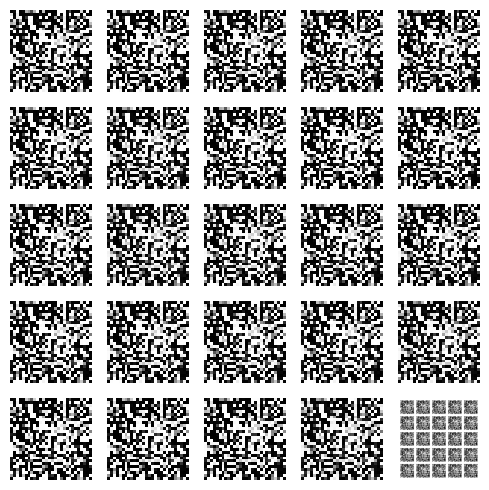

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|          | 1/350 [00:00<02:14,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|          | 2/350 [00:00<02:16,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|          | 3/350 [00:01<02:12,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|          | 4/350 [00:01<02:11,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▏         | 5/350 [00:01<02:11,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|▏         | 6/350 [00:02<02:10,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  2%|▏         | 7/350 [00:02<02:45,  2.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|▏         | 8/350 [00:03<02:33,  2.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|▎         | 9/350 [00:03<02:25,  2.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 10/350 [00:04<02:19,  2.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|▎         | 11/350 [00:04<02:15,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 12/350 [00:04<02:13,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  4%|▎         | 13/350 [00:05<02:21,  2.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  4%|▍         | 14/350 [00:05<02:36,  2.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▍         | 15/350 [00:06<02:46,  2.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|▍         | 16/350 [00:06<02:47,  2.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  5%|▍         | 17/350 [00:07<02:57,  1.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  5%|▌         | 18/350 [00:08<02:49,  1.96it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|▌         | 19/350 [00:08<02:37,  2.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|▌         | 20/350 [00:08<02:26,  2.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|▌         | 21/350 [00:09<02:21,  2.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|▋         | 22/350 [00:09<02:16,  2.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 23/350 [00:09<02:11,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  7%|▋         | 24/350 [00:10<02:09,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|▋         | 25/350 [00:10<02:06,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 26/350 [00:11<02:04,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  8%|▊         | 27/350 [00:11<02:05,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|▊         | 28/350 [00:11<02:02,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|▊         | 29/350 [00:12<02:01,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|▊         | 30/350 [00:12<02:03,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▉         | 31/350 [00:13<02:01,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▉         | 32/350 [00:13<02:01,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|▉         | 33/350 [00:13<02:00,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|▉         | 34/350 [00:14<01:59,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|█         | 35/350 [00:14<02:00,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 10%|█         | 36/350 [00:14<01:58,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█         | 37/350 [00:15<01:58,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 11%|█         | 38/350 [00:15<01:57,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█         | 39/350 [00:16<01:55,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█▏        | 40/350 [00:16<01:54,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█▏        | 41/350 [00:16<01:54,  2.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█▏        | 42/350 [00:17<01:53,  2.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█▏        | 43/350 [00:17<01:55,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█▎        | 44/350 [00:17<01:56,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|█▎        | 45/350 [00:18<02:14,  2.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 13%|█▎        | 46/350 [00:19<02:24,  2.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 13%|█▎        | 47/350 [00:19<02:30,  2.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 14%|█▎        | 48/350 [00:20<02:37,  1.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 14%|█▍        | 49/350 [00:20<02:37,  1.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|█▍        | 50/350 [00:21<02:22,  2.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▍        | 51/350 [00:21<02:12,  2.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▍        | 52/350 [00:21<02:08,  2.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|█▌        | 53/350 [00:22<02:02,  2.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▌        | 54/350 [00:22<01:58,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|█▌        | 55/350 [00:22<01:58,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|█▌        | 56/350 [00:23<01:55,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|█▋        | 57/350 [00:23<01:53,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█▋        | 58/350 [00:24<01:54,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█▋        | 59/350 [00:24<01:52,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█▋        | 60/350 [00:24<01:51,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█▋        | 61/350 [00:25<01:49,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█▊        | 62/350 [00:25<01:48,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█▊        | 63/350 [00:26<01:48,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█▊        | 64/350 [00:26<01:47,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|█▊        | 65/350 [00:26<01:46,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|█▉        | 66/350 [00:27<01:46,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|█▉        | 67/350 [00:27<01:47,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|█▉        | 68/350 [00:27<01:47,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|█▉        | 69/350 [00:28<01:47,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|██        | 70/350 [00:28<01:46,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|██        | 71/350 [00:29<01:46,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 72/350 [00:29<01:45,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|██        | 73/350 [00:29<01:44,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|██        | 74/350 [00:30<01:44,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|██▏       | 75/350 [00:30<01:44,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 22%|██▏       | 76/350 [00:31<01:57,  2.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 77/350 [00:31<02:04,  2.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 22%|██▏       | 78/350 [00:32<02:10,  2.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 23%|██▎       | 79/350 [00:32<02:19,  1.94it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 23%|██▎       | 80/350 [00:33<02:23,  1.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██▎       | 81/350 [00:33<02:10,  2.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██▎       | 82/350 [00:34<02:00,  2.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▎       | 83/350 [00:34<01:55,  2.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▍       | 84/350 [00:34<01:49,  2.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▍       | 85/350 [00:35<01:46,  2.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 25%|██▍       | 86/350 [00:35<01:46,  2.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|██▍       | 87/350 [00:36<01:45,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|██▌       | 88/350 [00:36<01:44,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██▌       | 89/350 [00:36<01:42,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|██▌       | 90/350 [00:37<01:40,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|██▌       | 91/350 [00:37<01:41,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 26%|██▋       | 92/350 [00:37<01:38,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 93/350 [00:38<01:37,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 94/350 [00:38<01:38,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 95/350 [00:39<01:36,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 96/350 [00:39<01:37,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|██▊       | 97/350 [00:39<01:37,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 98/350 [00:40<01:35,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|██▊       | 99/350 [00:40<01:36,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██▊       | 100/350 [00:40<01:34,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██▉       | 101/350 [00:41<01:32,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██▉       | 102/350 [00:41<01:33,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██▉       | 103/350 [00:42<01:32,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|██▉       | 104/350 [00:42<01:32,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|███       | 105/350 [00:42<01:32,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███       | 106/350 [00:43<01:30,  2.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 31%|███       | 107/350 [00:43<01:42,  2.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 31%|███       | 108/350 [00:44<01:49,  2.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|███       | 109/350 [00:44<01:57,  2.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 31%|███▏      | 110/350 [00:45<02:00,  2.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 32%|███▏      | 111/350 [00:45<02:04,  1.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 32%|███▏      | 112/350 [00:46<02:00,  1.98it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|███▏      | 113/350 [00:46<01:50,  2.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 33%|███▎      | 114/350 [00:47<01:44,  2.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|███▎      | 115/350 [00:47<01:39,  2.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|███▎      | 116/350 [00:47<01:35,  2.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|███▎      | 117/350 [00:48<01:34,  2.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|███▎      | 118/350 [00:48<01:31,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|███▍      | 119/350 [00:49<01:29,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 34%|███▍      | 120/350 [00:49<01:27,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|███▍      | 121/350 [00:49<01:26,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███▍      | 122/350 [00:50<01:25,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███▌      | 123/350 [00:50<01:24,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▌      | 124/350 [00:50<01:24,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 36%|███▌      | 125/350 [00:51<01:25,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 36%|███▌      | 126/350 [00:51<01:25,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███▋      | 127/350 [00:52<01:24,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███▋      | 128/350 [00:52<01:24,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███▋      | 129/350 [00:52<01:24,  2.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███▋      | 130/350 [00:53<01:23,  2.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 37%|███▋      | 131/350 [00:53<01:22,  2.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|███▊      | 132/350 [00:53<01:21,  2.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|███▊      | 133/350 [00:54<01:21,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|███▊      | 134/350 [00:54<01:21,  2.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|███▊      | 135/350 [00:55<01:20,  2.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 39%|███▉      | 136/350 [00:55<01:20,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|███▉      | 137/350 [00:55<01:20,  2.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|███▉      | 138/350 [00:56<01:21,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|███▉      | 139/350 [00:56<01:42,  2.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 40%|████      | 140/350 [00:57<01:46,  1.97it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|████      | 141/350 [00:58<01:50,  1.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 41%|████      | 142/350 [00:58<01:54,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|████      | 143/350 [00:59<01:43,  2.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|████      | 144/350 [00:59<01:35,  2.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|████▏     | 145/350 [00:59<01:30,  2.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████▏     | 146/350 [01:00<01:26,  2.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████▏     | 147/350 [01:00<01:24,  2.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████▏     | 148/350 [01:00<01:20,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|████▎     | 149/350 [01:01<01:19,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████▎     | 150/350 [01:01<01:18,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|████▎     | 151/350 [01:02<01:18,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 43%|████▎     | 152/350 [01:02<01:17,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 44%|████▎     | 153/350 [01:02<01:17,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|████▍     | 154/350 [01:03<01:16,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 44%|████▍     | 155/350 [01:03<01:16,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|████▍     | 156/350 [01:04<01:16,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 45%|████▍     | 157/350 [01:04<01:16,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|████▌     | 158/350 [01:04<01:16,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|████▌     | 159/350 [01:05<01:14,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|████▌     | 160/350 [01:05<01:13,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|████▌     | 161/350 [01:06<01:13,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|████▋     | 162/350 [01:06<01:12,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████▋     | 163/350 [01:06<01:13,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████▋     | 164/350 [01:07<01:12,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|████▋     | 165/350 [01:07<01:11,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████▋     | 166/350 [01:07<01:11,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 167/350 [01:08<01:10,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 168/350 [01:08<01:10,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 48%|████▊     | 169/350 [01:09<01:22,  2.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 49%|████▊     | 170/350 [01:09<01:24,  2.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 49%|████▉     | 171/350 [01:10<01:28,  2.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 49%|████▉     | 172/350 [01:10<01:32,  1.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▉     | 173/350 [01:11<01:35,  1.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|████▉     | 174/350 [01:11<01:26,  2.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 50%|█████     | 175/350 [01:12<01:21,  2.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|█████     | 176/350 [01:12<01:17,  2.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 51%|█████     | 177/350 [01:13<01:14,  2.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 51%|█████     | 178/350 [01:13<01:11,  2.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 51%|█████     | 179/350 [01:13<01:09,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████▏    | 180/350 [01:14<01:08,  2.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|█████▏    | 181/350 [01:14<01:06,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 52%|█████▏    | 182/350 [01:15<01:05,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 52%|█████▏    | 183/350 [01:15<01:05,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 53%|█████▎    | 184/350 [01:15<01:04,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████▎    | 185/350 [01:16<01:04,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 53%|█████▎    | 186/350 [01:16<01:04,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 53%|█████▎    | 187/350 [01:17<01:03,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▎    | 188/350 [01:17<01:03,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████▍    | 189/350 [01:17<01:02,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████▍    | 190/350 [01:18<01:01,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 55%|█████▍    | 191/350 [01:18<01:02,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████▍    | 192/350 [01:18<01:01,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▌    | 193/350 [01:19<01:00,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████▌    | 194/350 [01:19<01:00,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▌    | 195/350 [01:20<00:59,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▌    | 196/350 [01:20<00:59,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|█████▋    | 197/350 [01:20<00:59,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 198/350 [01:21<00:58,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|█████▋    | 199/350 [01:21<01:02,  2.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 57%|█████▋    | 200/350 [01:22<01:07,  2.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 57%|█████▋    | 201/350 [01:23<01:18,  1.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|█████▊    | 202/350 [01:23<01:21,  1.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 58%|█████▊    | 203/350 [01:24<01:21,  1.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████▊    | 204/350 [01:24<01:14,  1.96it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████▊    | 205/350 [01:24<01:08,  2.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████▉    | 206/350 [01:25<01:04,  2.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████▉    | 207/350 [01:25<01:02,  2.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████▉    | 208/350 [01:26<00:59,  2.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|█████▉    | 209/350 [01:26<00:57,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 60%|██████    | 210/350 [01:26<00:57,  2.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|██████    | 211/350 [01:27<00:56,  2.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|██████    | 212/350 [01:27<00:56,  2.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|██████    | 213/350 [01:28<00:54,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|██████    | 214/350 [01:28<00:54,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 61%|██████▏   | 215/350 [01:28<00:54,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 62%|██████▏   | 216/350 [01:29<00:53,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 62%|██████▏   | 217/350 [01:29<00:52,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 218/350 [01:30<00:51,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 63%|██████▎   | 219/350 [01:30<00:50,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 63%|██████▎   | 220/350 [01:30<00:51,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 63%|██████▎   | 221/350 [01:31<00:50,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 63%|██████▎   | 222/350 [01:31<00:49,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|██████▎   | 223/350 [01:32<00:49,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|██████▍   | 224/350 [01:32<00:48,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 64%|██████▍   | 225/350 [01:32<00:48,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|██████▍   | 226/350 [01:33<00:48,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|██████▍   | 227/350 [01:33<00:47,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|██████▌   | 228/350 [01:33<00:47,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|██████▌   | 229/350 [01:34<00:51,  2.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 66%|██████▌   | 230/350 [01:35<00:56,  2.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 66%|██████▌   | 231/350 [01:35<00:58,  2.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 66%|██████▋   | 232/350 [01:36<00:59,  1.98it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████▋   | 233/350 [01:36<01:04,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 67%|██████▋   | 234/350 [01:37<01:00,  1.91it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|██████▋   | 235/350 [01:37<00:55,  2.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|██████▋   | 236/350 [01:38<00:51,  2.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 68%|██████▊   | 237/350 [01:38<00:50,  2.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████▊   | 238/350 [01:38<00:48,  2.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|██████▊   | 239/350 [01:39<00:46,  2.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████▊   | 240/350 [01:39<00:44,  2.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████▉   | 241/350 [01:39<00:43,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|██████▉   | 242/350 [01:40<00:42,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|██████▉   | 243/350 [01:40<00:41,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 70%|██████▉   | 244/350 [01:41<00:41,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|███████   | 245/350 [01:41<00:41,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|███████   | 246/350 [01:41<00:40,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████   | 247/350 [01:42<00:40,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|███████   | 248/350 [01:42<00:40,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████   | 249/350 [01:43<00:39,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████▏  | 250/350 [01:43<00:39,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|███████▏  | 251/350 [01:43<00:38,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 252/350 [01:44<00:37,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 72%|███████▏  | 253/350 [01:44<00:39,  2.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|███████▎  | 254/350 [01:45<00:37,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 255/350 [01:45<00:37,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|███████▎  | 256/350 [01:45<00:36,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 257/350 [01:46<00:36,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▎  | 258/350 [01:46<00:36,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|███████▍  | 259/350 [01:47<00:36,  2.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 74%|███████▍  | 260/350 [01:47<00:40,  2.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 75%|███████▍  | 261/350 [01:48<00:43,  2.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 75%|███████▍  | 262/350 [01:48<00:46,  1.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 75%|███████▌  | 263/350 [01:49<00:48,  1.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 75%|███████▌  | 264/350 [01:49<00:45,  1.90it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████▌  | 265/350 [01:50<00:41,  2.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|███████▌  | 266/350 [01:50<00:37,  2.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 76%|███████▋  | 267/350 [01:51<00:35,  2.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████▋  | 268/350 [01:51<00:34,  2.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████▋  | 269/350 [01:51<00:33,  2.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 77%|███████▋  | 270/350 [01:52<00:32,  2.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|███████▋  | 271/350 [01:52<00:31,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|███████▊  | 272/350 [01:53<00:31,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|███████▊  | 273/350 [01:53<00:30,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████▊  | 274/350 [01:53<00:29,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 79%|███████▊  | 275/350 [01:54<00:29,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|███████▉  | 276/350 [01:54<00:28,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 79%|███████▉  | 277/350 [01:54<00:28,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|███████▉  | 278/350 [01:55<00:28,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|███████▉  | 279/350 [01:55<00:27,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████  | 280/350 [01:56<00:27,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████  | 281/350 [01:56<00:26,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 282/350 [01:56<00:26,  2.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 81%|████████  | 283/350 [01:57<00:26,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|████████  | 284/350 [01:57<00:25,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 81%|████████▏ | 285/350 [01:58<00:25,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 82%|████████▏ | 286/350 [01:58<00:25,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 82%|████████▏ | 287/350 [01:58<00:24,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 82%|████████▏ | 288/350 [01:59<00:24,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 83%|████████▎ | 289/350 [01:59<00:23,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 83%|████████▎ | 290/350 [02:00<00:26,  2.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 83%|████████▎ | 291/350 [02:00<00:28,  2.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 83%|████████▎ | 292/350 [02:01<00:29,  1.96it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 84%|████████▎ | 293/350 [02:01<00:29,  1.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 84%|████████▍ | 294/350 [02:02<00:31,  1.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|████████▍ | 295/350 [02:02<00:28,  1.94it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|████████▍ | 296/350 [02:03<00:25,  2.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|████████▍ | 297/350 [02:03<00:24,  2.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|████████▌ | 298/350 [02:04<00:22,  2.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|████████▌ | 299/350 [02:04<00:21,  2.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|████████▌ | 300/350 [02:04<00:20,  2.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|████████▌ | 301/350 [02:05<00:19,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 86%|████████▋ | 302/350 [02:05<00:19,  2.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 87%|████████▋ | 303/350 [02:06<00:18,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|████████▋ | 304/350 [02:06<00:18,  2.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|████████▋ | 305/350 [02:06<00:18,  2.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|████████▋ | 306/350 [02:07<00:18,  2.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████▊ | 307/350 [02:07<00:17,  2.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████▊ | 308/350 [02:08<00:16,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 88%|████████▊ | 309/350 [02:08<00:16,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|████████▊ | 310/350 [02:08<00:15,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 89%|████████▉ | 311/350 [02:09<00:15,  2.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|████████▉ | 312/350 [02:09<00:15,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▉ | 313/350 [02:10<00:14,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|████████▉ | 314/350 [02:10<00:13,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|█████████ | 315/350 [02:10<00:13,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|█████████ | 316/350 [02:11<00:13,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|█████████ | 317/350 [02:11<00:12,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████ | 318/350 [02:12<00:12,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|█████████ | 319/350 [02:12<00:12,  2.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 91%|█████████▏| 320/350 [02:13<00:13,  2.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 92%|█████████▏| 321/350 [02:13<00:13,  2.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 92%|█████████▏| 322/350 [02:14<00:14,  1.97it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 92%|█████████▏| 323/350 [02:14<00:14,  1.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 93%|█████████▎| 324/350 [02:15<00:14,  1.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|█████████▎| 325/350 [02:15<00:12,  2.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 326/350 [02:16<00:11,  2.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 327/350 [02:16<00:10,  2.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|█████████▎| 328/350 [02:16<00:09,  2.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|█████████▍| 329/350 [02:17<00:08,  2.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|█████████▍| 330/350 [02:17<00:08,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|█████████▍| 331/350 [02:18<00:07,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|█████████▍| 332/350 [02:18<00:07,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|█████████▌| 333/350 [02:18<00:06,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|█████████▌| 334/350 [02:19<00:06,  2.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 96%|█████████▌| 335/350 [02:19<00:05,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 96%|█████████▌| 336/350 [02:20<00:05,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|█████████▋| 337/350 [02:20<00:05,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████▋| 338/350 [02:20<00:04,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████▋| 339/350 [02:21<00:04,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████▋| 340/350 [02:21<00:03,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|█████████▋| 341/350 [02:22<00:03,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|█████████▊| 342/350 [02:22<00:03,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|█████████▊| 343/350 [02:22<00:02,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|█████████▊| 344/350 [02:23<00:02,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▊| 345/350 [02:23<00:01,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▉| 346/350 [02:24<00:01,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▉| 347/350 [02:24<00:01,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▉| 348/350 [02:24<00:00,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|█████████▉| 349/350 [02:25<00:00,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 350/350 [02:25<00:00,  2.40it/s]

Epoch number: 3 discriminator_loss: 1.2344466280937194 generator_loss: 0.35496686986514503
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


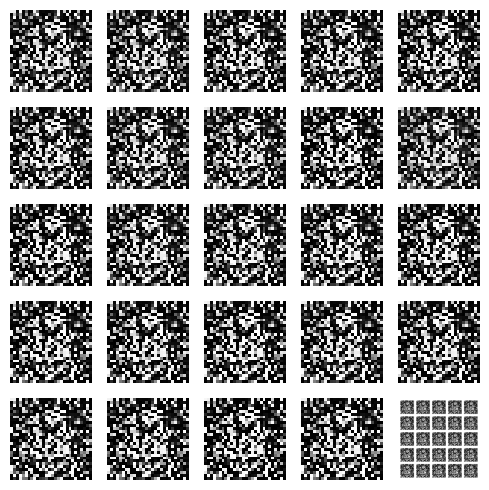

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 1/350 [00:00<03:20,  1.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 2/350 [00:01<03:26,  1.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  1%|          | 3/350 [00:01<03:14,  1.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|          | 4/350 [00:02<02:51,  2.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▏         | 5/350 [00:02<02:35,  2.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|▏         | 6/350 [00:02<02:27,  2.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  2%|▏         | 7/350 [00:03<02:24,  2.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|▏         | 8/350 [00:03<02:20,  2.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|▎         | 9/350 [00:04<02:17,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|▎         | 10/350 [00:04<02:15,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|▎         | 11/350 [00:04<02:13,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|▎         | 12/350 [00:05<02:14,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|▎         | 13/350 [00:05<02:12,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|▍         | 14/350 [00:05<02:11,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  4%|▍         | 15/350 [00:06<02:16,  2.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|▍         | 16/350 [00:06<02:13,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|▍         | 17/350 [00:07<02:13,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|▌         | 18/350 [00:07<02:12,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|▌         | 19/350 [00:08<02:12,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|▌         | 20/350 [00:08<02:12,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|▌         | 21/350 [00:08<02:10,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|▋         | 22/350 [00:09<02:08,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|▋         | 23/350 [00:09<02:09,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  7%|▋         | 24/350 [00:09<02:07,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|▋         | 25/350 [00:10<02:11,  2.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  7%|▋         | 26/350 [00:10<02:08,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|▊         | 27/350 [00:11<02:06,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  8%|▊         | 28/350 [00:11<02:08,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  8%|▊         | 29/350 [00:12<02:25,  2.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  9%|▊         | 30/350 [00:12<02:32,  2.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  9%|▉         | 31/350 [00:13<02:39,  1.99it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 32/350 [00:13<02:49,  1.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  9%|▉         | 33/350 [00:14<02:54,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|▉         | 34/350 [00:14<02:44,  1.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|█         | 35/350 [00:15<02:31,  2.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|█         | 36/350 [00:15<02:24,  2.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█         | 37/350 [00:16<02:15,  2.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█         | 38/350 [00:16<02:09,  2.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|█         | 39/350 [00:16<02:07,  2.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|█▏        | 40/350 [00:17<02:03,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█▏        | 41/350 [00:17<02:01,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 12%|█▏        | 42/350 [00:18<02:03,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|█▏        | 43/350 [00:18<02:02,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█▎        | 44/350 [00:18<02:02,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|█▎        | 45/350 [00:19<02:00,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█▎        | 46/350 [00:19<01:57,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|█▎        | 47/350 [00:19<01:58,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|█▎        | 48/350 [00:20<01:56,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|█▍        | 49/350 [00:20<01:55,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 14%|█▍        | 50/350 [00:21<01:56,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|█▍        | 51/350 [00:21<01:55,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|█▍        | 52/350 [00:21<01:56,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▌        | 53/350 [00:22<01:55,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 15%|█▌        | 54/350 [00:22<01:55,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|█▌        | 55/350 [00:23<01:55,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 16%|█▌        | 56/350 [00:23<01:52,  2.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|█▋        | 57/350 [00:23<01:52,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 17%|█▋        | 58/350 [00:24<01:57,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█▋        | 59/350 [00:24<02:02,  2.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 17%|█▋        | 60/350 [00:25<02:17,  2.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 17%|█▋        | 61/350 [00:25<02:23,  2.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 18%|█▊        | 62/350 [00:26<02:31,  1.90it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 63/350 [00:27<02:37,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█▊        | 64/350 [00:27<02:30,  1.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|█▊        | 65/350 [00:27<02:18,  2.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|█▉        | 66/350 [00:28<02:10,  2.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 19%|█▉        | 67/350 [00:28<02:04,  2.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|█▉        | 68/350 [00:29<01:59,  2.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 20%|█▉        | 69/350 [00:29<01:57,  2.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|██        | 70/350 [00:29<01:55,  2.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|██        | 71/350 [00:30<01:53,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|██        | 72/350 [00:30<01:51,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|██        | 73/350 [00:31<01:50,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|██        | 74/350 [00:31<01:51,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|██▏       | 75/350 [00:31<01:50,  2.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|██▏       | 76/350 [00:32<01:49,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|██▏       | 77/350 [00:32<01:48,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 22%|██▏       | 78/350 [00:33<01:47,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██▎       | 79/350 [00:33<01:46,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██▎       | 80/350 [00:33<01:46,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|██▎       | 81/350 [00:34<01:44,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 23%|██▎       | 82/350 [00:34<01:45,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██▎       | 83/350 [00:35<01:44,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██▍       | 84/350 [00:35<01:43,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▍       | 85/350 [00:35<01:43,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|██▍       | 86/350 [00:36<01:43,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|██▍       | 87/350 [00:36<01:44,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|██▌       | 88/350 [00:37<01:46,  2.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|██▌       | 89/350 [00:37<01:49,  2.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▌       | 90/350 [00:38<01:59,  2.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 26%|██▌       | 91/350 [00:38<02:11,  1.97it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▋       | 92/350 [00:39<02:15,  1.90it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|██▋       | 93/350 [00:39<02:23,  1.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|██▋       | 94/350 [00:40<02:12,  1.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 27%|██▋       | 95/350 [00:40<02:03,  2.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 27%|██▋       | 96/350 [00:41<01:58,  2.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|██▊       | 97/350 [00:41<01:52,  2.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|██▊       | 98/350 [00:41<01:48,  2.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|██▊       | 99/350 [00:42<01:43,  2.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██▊       | 100/350 [00:42<01:41,  2.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|██▉       | 101/350 [00:43<01:40,  2.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██▉       | 102/350 [00:43<01:39,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|██▉       | 103/350 [00:43<01:39,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|██▉       | 104/350 [00:44<01:38,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|███       | 105/350 [00:44<01:37,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███       | 106/350 [00:45<01:36,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|███       | 107/350 [00:45<01:36,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███       | 108/350 [00:45<01:35,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███       | 109/350 [00:46<01:35,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 31%|███▏      | 110/350 [00:46<01:35,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███▏      | 111/350 [00:47<01:33,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███▏      | 112/350 [00:47<01:33,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|███▏      | 113/350 [00:47<01:32,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|███▎      | 114/350 [00:48<01:32,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|███▎      | 115/350 [00:48<01:32,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 33%|███▎      | 116/350 [00:48<01:31,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|███▎      | 117/350 [00:49<01:31,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|███▎      | 118/350 [00:49<01:30,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|███▍      | 119/350 [00:50<01:36,  2.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▍      | 120/350 [00:50<01:57,  1.96it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 35%|███▍      | 121/350 [00:51<01:57,  1.95it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 35%|███▍      | 122/350 [00:52<01:58,  1.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|███▌      | 123/350 [00:52<02:03,  1.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 35%|███▌      | 124/350 [00:53<01:57,  1.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███▌      | 125/350 [00:53<01:49,  2.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███▌      | 126/350 [00:53<01:42,  2.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███▋      | 127/350 [00:54<01:37,  2.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 128/350 [00:54<01:35,  2.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 37%|███▋      | 129/350 [00:55<01:33,  2.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 37%|███▋      | 130/350 [00:55<01:32,  2.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|███▋      | 131/350 [00:55<01:31,  2.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|███▊      | 132/350 [00:56<01:28,  2.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|███▊      | 133/350 [00:56<01:27,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|███▊      | 134/350 [00:57<01:25,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|███▊      | 135/350 [00:57<01:23,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|███▉      | 136/350 [00:57<01:24,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|███▉      | 137/350 [00:58<01:23,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|███▉      | 138/350 [00:58<01:23,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|███▉      | 139/350 [00:59<01:22,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|████      | 140/350 [00:59<01:21,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|████      | 141/350 [00:59<01:22,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|████      | 142/350 [01:00<01:21,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|████      | 143/350 [01:00<01:20,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|████      | 144/350 [01:00<01:21,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|████▏     | 145/350 [01:01<01:19,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 42%|████▏     | 146/350 [01:01<01:19,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████▏     | 147/350 [01:02<01:18,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████▏     | 148/350 [01:02<01:18,  2.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|████▎     | 149/350 [01:03<01:23,  2.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 43%|████▎     | 150/350 [01:03<01:31,  2.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 43%|████▎     | 151/350 [01:04<01:36,  2.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 43%|████▎     | 152/350 [01:04<01:38,  2.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▎     | 153/350 [01:05<01:53,  1.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|████▍     | 154/350 [01:05<01:42,  1.91it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 44%|████▍     | 155/350 [01:06<01:37,  2.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|████▍     | 156/350 [01:06<01:29,  2.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 45%|████▍     | 157/350 [01:07<01:26,  2.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|████▌     | 158/350 [01:07<01:21,  2.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 45%|████▌     | 159/350 [01:07<01:18,  2.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 46%|████▌     | 160/350 [01:08<01:17,  2.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 46%|████▌     | 161/350 [01:08<01:16,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 46%|████▋     | 162/350 [01:08<01:15,  2.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|████▋     | 163/350 [01:09<01:15,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████▋     | 164/350 [01:09<01:13,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████▋     | 165/350 [01:10<01:14,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████▋     | 166/350 [01:10<01:12,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 48%|████▊     | 167/350 [01:10<01:14,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 48%|████▊     | 168/350 [01:11<01:15,  2.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 169/350 [01:11<01:13,  2.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|████▊     | 170/350 [01:12<01:13,  2.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████▉     | 171/350 [01:12<01:11,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 49%|████▉     | 172/350 [01:12<01:10,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 49%|████▉     | 173/350 [01:13<01:09,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|████▉     | 174/350 [01:13<01:08,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|█████     | 175/350 [01:14<01:08,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 50%|█████     | 176/350 [01:14<01:08,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████     | 177/350 [01:14<01:07,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 51%|█████     | 178/350 [01:15<01:07,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 51%|█████     | 179/350 [01:15<01:13,  2.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 51%|█████▏    | 180/350 [01:16<01:20,  2.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 52%|█████▏    | 181/350 [01:17<01:27,  1.94it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 52%|█████▏    | 182/350 [01:17<01:29,  1.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 52%|█████▏    | 183/350 [01:18<01:31,  1.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 53%|█████▎    | 184/350 [01:18<01:24,  1.97it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|█████▎    | 185/350 [01:18<01:18,  2.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 53%|█████▎    | 186/350 [01:19<01:13,  2.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 53%|█████▎    | 187/350 [01:19<01:13,  2.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▎    | 188/350 [01:20<01:09,  2.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 54%|█████▍    | 189/350 [01:20<01:08,  2.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|█████▍    | 190/350 [01:21<01:06,  2.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████▍    | 191/350 [01:21<01:04,  2.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 55%|█████▍    | 192/350 [01:21<01:06,  2.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 55%|█████▌    | 193/350 [01:22<01:04,  2.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 55%|█████▌    | 194/350 [01:22<01:03,  2.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 56%|█████▌    | 195/350 [01:23<01:02,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▌    | 196/350 [01:23<01:00,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▋    | 197/350 [01:23<01:00,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|█████▋    | 198/350 [01:24<01:01,  2.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|█████▋    | 199/350 [01:24<01:00,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|█████▋    | 200/350 [01:25<01:00,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|█████▋    | 201/350 [01:25<00:59,  2.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████▊    | 202/350 [01:25<00:59,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|█████▊    | 203/350 [01:26<00:58,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|█████▊    | 204/350 [01:26<00:58,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 59%|█████▊    | 205/350 [01:27<00:59,  2.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████▉    | 206/350 [01:27<00:58,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████▉    | 207/350 [01:27<00:58,  2.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 59%|█████▉    | 208/350 [01:28<00:56,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 60%|█████▉    | 209/350 [01:28<01:03,  2.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 60%|██████    | 210/350 [01:29<01:07,  2.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 60%|██████    | 211/350 [01:29<01:10,  1.98it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 61%|██████    | 212/350 [01:30<01:12,  1.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 213/350 [01:31<01:15,  1.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|██████    | 214/350 [01:31<01:08,  1.98it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 61%|██████▏   | 215/350 [01:31<01:04,  2.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 62%|██████▏   | 216/350 [01:32<01:00,  2.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 62%|██████▏   | 217/350 [01:32<00:57,  2.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 62%|██████▏   | 218/350 [01:33<00:55,  2.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 63%|██████▎   | 219/350 [01:33<00:54,  2.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 63%|██████▎   | 220/350 [01:33<00:53,  2.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 63%|██████▎   | 221/350 [01:34<00:52,  2.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 63%|██████▎   | 222/350 [01:34<00:51,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████▎   | 223/350 [01:35<00:50,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 64%|██████▍   | 224/350 [01:35<00:51,  2.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 64%|██████▍   | 225/350 [01:35<00:50,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|██████▍   | 226/350 [01:36<00:49,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|██████▍   | 227/350 [01:36<00:49,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|██████▌   | 228/350 [01:37<00:48,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 65%|██████▌   | 229/350 [01:37<00:47,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████▌   | 230/350 [01:37<00:47,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 66%|██████▌   | 231/350 [01:38<00:46,  2.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 66%|██████▋   | 232/350 [01:38<00:46,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|██████▋   | 233/350 [01:39<00:46,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|██████▋   | 234/350 [01:39<00:45,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|██████▋   | 235/350 [01:39<00:45,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|██████▋   | 236/350 [01:40<00:44,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████▊   | 237/350 [01:40<00:45,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 68%|██████▊   | 238/350 [01:41<00:47,  2.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 239/350 [01:41<00:52,  2.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 69%|██████▊   | 240/350 [01:42<00:55,  1.97it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 69%|██████▉   | 241/350 [01:42<00:58,  1.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 69%|██████▉   | 242/350 [01:43<01:00,  1.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 69%|██████▉   | 243/350 [01:44<01:02,  1.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 70%|██████▉   | 244/350 [01:44<00:55,  1.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|███████   | 245/350 [01:44<00:52,  2.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|███████   | 246/350 [01:45<00:48,  2.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|███████   | 247/350 [01:45<00:45,  2.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|███████   | 248/350 [01:46<00:43,  2.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 71%|███████   | 249/350 [01:46<00:42,  2.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|███████▏  | 250/350 [01:46<00:41,  2.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 251/350 [01:47<00:40,  2.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|███████▏  | 252/350 [01:47<00:39,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|███████▏  | 253/350 [01:48<00:38,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 254/350 [01:48<00:37,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|███████▎  | 255/350 [01:48<00:37,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 256/350 [01:49<00:36,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 73%|███████▎  | 257/350 [01:49<00:36,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 74%|███████▎  | 258/350 [01:50<00:36,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|███████▍  | 259/350 [01:50<00:35,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 74%|███████▍  | 260/350 [01:50<00:35,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|███████▍  | 261/350 [01:51<00:34,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 75%|███████▍  | 262/350 [01:51<00:34,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|███████▌  | 263/350 [01:52<00:34,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 75%|███████▌  | 264/350 [01:52<00:34,  2.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 76%|███████▌  | 265/350 [01:52<00:34,  2.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 76%|███████▌  | 266/350 [01:53<00:34,  2.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 76%|███████▋  | 267/350 [01:53<00:33,  2.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|███████▋  | 268/350 [01:54<00:36,  2.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 77%|███████▋  | 269/350 [01:54<00:39,  2.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 270/350 [01:55<00:41,  1.92it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 77%|███████▋  | 271/350 [01:56<00:42,  1.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 78%|███████▊  | 272/350 [01:56<00:43,  1.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 78%|███████▊  | 273/350 [01:57<00:40,  1.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|███████▊  | 274/350 [01:57<00:37,  2.04it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 79%|███████▊  | 275/350 [01:57<00:34,  2.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|███████▉  | 276/350 [01:58<00:32,  2.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|███████▉  | 277/350 [01:58<00:31,  2.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 79%|███████▉  | 278/350 [01:59<00:29,  2.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|███████▉  | 279/350 [01:59<00:28,  2.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████  | 280/350 [01:59<00:28,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████  | 281/350 [02:00<00:27,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 81%|████████  | 282/350 [02:00<00:27,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|████████  | 283/350 [02:01<00:26,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|████████  | 284/350 [02:01<00:26,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|████████▏ | 285/350 [02:01<00:25,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|████████▏ | 286/350 [02:02<00:25,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 82%|████████▏ | 287/350 [02:02<00:25,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 82%|████████▏ | 288/350 [02:02<00:24,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 289/350 [02:03<00:23,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 83%|████████▎ | 290/350 [02:03<00:23,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████▎ | 291/350 [02:04<00:23,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 83%|████████▎ | 292/350 [02:04<00:22,  2.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|████████▎ | 293/350 [02:04<00:22,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|████████▍ | 294/350 [02:05<00:21,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|████████▍ | 295/350 [02:05<00:21,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 85%|████████▍ | 296/350 [02:06<00:21,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|████████▍ | 297/350 [02:06<00:20,  2.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|████████▌ | 298/350 [02:06<00:21,  2.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 85%|████████▌ | 299/350 [02:07<00:23,  2.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 86%|████████▌ | 300/350 [02:08<00:24,  2.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 86%|████████▌ | 301/350 [02:08<00:25,  1.90it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 86%|████████▋ | 302/350 [02:09<00:25,  1.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 87%|████████▋ | 303/350 [02:09<00:26,  1.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|████████▋ | 304/350 [02:10<00:23,  1.95it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 87%|████████▋ | 305/350 [02:10<00:21,  2.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|████████▋ | 306/350 [02:11<00:20,  2.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 88%|████████▊ | 307/350 [02:11<00:18,  2.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 88%|████████▊ | 308/350 [02:11<00:18,  2.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████▊ | 309/350 [02:12<00:17,  2.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 89%|████████▊ | 310/350 [02:12<00:16,  2.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|████████▉ | 311/350 [02:13<00:15,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 89%|████████▉ | 312/350 [02:13<00:15,  2.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 89%|████████▉ | 313/350 [02:13<00:15,  2.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|████████▉ | 314/350 [02:14<00:14,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 90%|█████████ | 315/350 [02:14<00:13,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|█████████ | 316/350 [02:15<00:13,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 91%|█████████ | 317/350 [02:15<00:13,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|█████████ | 318/350 [02:15<00:12,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|█████████ | 319/350 [02:16<00:12,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 91%|█████████▏| 320/350 [02:16<00:11,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|█████████▏| 321/350 [02:17<00:11,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|█████████▏| 322/350 [02:17<00:11,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|█████████▏| 323/350 [02:17<00:10,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|█████████▎| 324/350 [02:18<00:10,  2.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 325/350 [02:18<00:09,  2.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 326/350 [02:19<00:09,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|█████████▎| 327/350 [02:19<00:09,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 94%|█████████▎| 328/350 [02:19<00:09,  2.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 94%|█████████▍| 329/350 [02:20<00:10,  1.93it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 94%|█████████▍| 330/350 [02:21<00:10,  1.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 95%|█████████▍| 331/350 [02:21<00:10,  1.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 95%|█████████▍| 332/350 [02:22<00:10,  1.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 95%|█████████▌| 333/350 [02:22<00:08,  1.94it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|█████████▌| 334/350 [02:23<00:07,  2.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|█████████▌| 335/350 [02:23<00:06,  2.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|█████████▌| 336/350 [02:24<00:06,  2.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|█████████▋| 337/350 [02:24<00:05,  2.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████▋| 338/350 [02:24<00:04,  2.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████▋| 339/350 [02:25<00:04,  2.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|█████████▋| 340/350 [02:25<00:04,  2.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 97%|█████████▋| 341/350 [02:26<00:03,  2.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|█████████▊| 342/350 [02:26<00:03,  2.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|█████████▊| 343/350 [02:26<00:02,  2.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 98%|█████████▊| 344/350 [02:27<00:02,  2.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▊| 345/350 [02:27<00:01,  2.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▉| 346/350 [02:28<00:01,  2.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|█████████▉| 347/350 [02:28<00:01,  2.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|█████████▉| 348/350 [02:28<00:00,  2.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


100%|█████████▉| 349/350 [02:29<00:00,  2.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


100%|██████████| 350/350 [02:29<00:00,  2.34it/s]

Epoch number: 4 discriminator_loss: 1.1816288409914288 generator_loss: 0.37304922674383434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


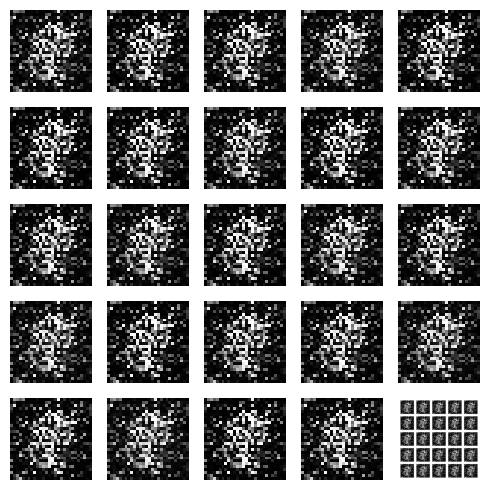

In [21]:
# To see some progress, we use tqdm as a progress bar
from tqdm import tqdm

# Since we do NOT use fit
# sadly, we have to do this ourselves manually
history = {"discriminator":[],"generator":[]}

# Main training loop
for epoch_num in range(EPOCHS):
    epoch_discriminator_loss = 0
    epoch_generator_loss = 0

    for batch in tqdm(range(BATCH_NUM)):
        # We select randomly a half batch amount of real images from MNIST
        # Use Numpy to choose, no replacement!
        idx = np.random.choice(data.shape[0], size=HALF_BATCH, replace=False)
        real_images = data[idx]

        # We generate a half batch amount of fake images
        # By first generating a half batch worth of Gaussian noise with zero mean, unit variance
        # and appropriate noise dimensions
        input_noise = np.random.normal(0,1, size=(HALF_BATCH,Z_DIM))
        # Then using the generator
        # And then using the fixed generator, to output some images from it
        # Using the predict method of the generator!
        generated_images = generator.predict(input_noise)
        # STOP, and thik through, WHY predict?!
        # Then you can remove the ....

        # We generate our "labels"
        # Remember one sided label smoothing for the positive class!
        # Let's say with 0.9...
        # So please, generate a half batch sized, one dimensional matrix with ones, using numpy
        # and multiuply it by 0.9
        real_y = np.ones(HALF_BATCH) * 0.9
        # And generate a half batch worth of zeroes, again one dimensional matrix
        generated_y = np.zeros(HALF_BATCH)


        ### We do the actual training!

        # First for the discriminator on the real data
        discriminator_loss_real = discriminator.train_on_batch(real_images, real_y)

        # Then on the fake data
        discriminator_loss_generated = discriminator.train_on_batch(generated_images, generated_y)

        # Then average the two losses
        discriminator_loss = (discriminator_loss_real + discriminator_loss_generated) / 2
        epoch_discriminator_loss += discriminator_loss

        ### We then update the generator
        # We use the discriminator that was trained a line above, and is frozen, as defined in the joint model

        # Please generate a new set of input noise, notice, it is a full batch!
        # Again, using numpy, normal distribution, zero mean, unit variance
        new_input_noise = np.random.normal(0,1, size=(BATCH_SIZE,Z_DIM))

        # We try to convince the discriminator, that this is real data - which is not
        # So please generate a batch worht of one dimensional matrix filled with ones
        convincing_y = np.ones(BATCH_SIZE)
        # Notice, no label smoothing!

        # Remember, the joint model takes in noise, does the generation, the discrimination, then computes loss
        # But the discriminator is frozen, so only the generator will get updated
        # It is "successful" if the discriminator predicts "real" - hence the convincing_y
        generator_loss = joint_model.train_on_batch(new_input_noise, convincing_y)
        epoch_generator_loss += generator_loss

    # Loss printout in every epoch, averaged over the batches
    print("Epoch number:",epoch_num,"discriminator_loss:",epoch_discriminator_loss / BATCH_NUM, "generator_loss:", epoch_generator_loss / BATCH_NUM)

    # Save it for the future
    history["discriminator"].append(epoch_discriminator_loss / BATCH_NUM)
    history["generator"].append(epoch_generator_loss / BATCH_NUM)

    #Save model - optional
    #generator.save("generator.h5")

    #Save images
    get_example_images(epoch_num)

    # Show epoch example
    show_image_for_epoch(epoch_num)

## Visualization of training progress

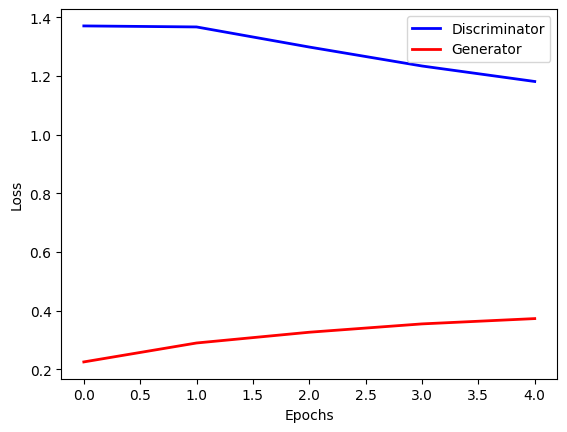

In [22]:
plt.plot(history["discriminator"], color='blue', linewidth=2, label="Discriminator")
plt.plot(history["generator"],  color='red', linewidth=2, label="Generator")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();
